In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import csv
from scipy import integrate
from car_park_functions import *
import math

In [2]:
bolTrainagain = False # will try to load data if false 

In [3]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=7
# problems on Weekend with 2 SantBoi, 4 Cerdanyola, 
# bad data: 6 Martorell, 8 SantQuirze DO NOT USE
#good 0 Vilanova, 1 SantSadurni, 3 QuatreCamins, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
# needs treshold  3 QuatreCamins, 2 SantBoi,  7 Mollet 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]


# loadind data:
    # Getting back the objects:
with open('data/'+current_parking+'_normalized.pkl','rb') as f:  # Python 3: open(..., 'rb')
    df_normalized, weekday_offset, friday_offset,  weekend_offset, max_value= pickle.load(f)
    f.close()
axis_ylim = max_value+20

df_training, df_testing = split_data(df_normalized, 3)



df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

friday_max = df_mean_areas.iloc[0]['MaxV']
weekday_max = df_mean_areas.iloc[1]['MaxV']
weekend_max = df_mean_areas.iloc[2]['MaxV']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

print('Weekday maximum: ' , weekday_max)
print('Friday maximum: ' , friday_max)
print('Weekend maximum: ' , weekend_max)

Weekday area:  4929.808641975347
Friday area:  4763.91666666666
Weekend area:  1473.9833333333395
Weekday maximum:  205.07407407407408
Friday maximum:  198.16666666666666
Weekend maximum:  65.1


## MATHEMATICAL MODEL - CDF Subtraction

In [4]:
# ********************************************** WEEKDAY *************************************************************
#from scipy.special import tna, factorial
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)
time_tn=time/24


#training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
#training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
#training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)

training_weekends_norm = training_weekends_norm[:-1]

training_weekdays_isfull  = get_parkingfull_of_protos("Weekday", df_training)
training_weekdays_date  =  get_dates_of_protos("Weekday", df_training)
training_fridays_isfull  = get_parkingfull_of_protos("Friday", df_training)
training_fridays_date  =  get_dates_of_protos("Friday", df_training)
training_weekends_date  =  get_dates_of_protos("Weekday", df_training)

# training_weekends_norm = t
wd_length = len(training_weekdays_norm)
f_length = len(training_fridays_norm)
we_length = len(training_weekends_norm)

#parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_weekdaytn = minimize(model_tn_areaN, parameters_tn, args=(training_weekdays_norm), method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})

if not(bolTrainagain):
    try:
        with open('data/'+current_parking+'_modelFitTH.pkl','rb') as f:  # Python 3: open(..., 'rb')
            [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
             errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
            f.close()
    except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
        print('no saved data: recalcualting')
        bolTrainagain = True

if bolTrainagain:
    errors_wd = np.ones(np.shape(training_weekdays_norm))

    parameters_tn_th_ind = np.array([.2 ,.05,.7,.1] + [.8]*wd_length)

    optimal_params_weekdaytn = minimize(model_tn_th_ind_max, 
                                    parameters_tn_th_ind, 
                                    args=(training_weekdays_norm,training_weekdays_isfull,errors_wd),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})


no saved data: recalcualting
Optimization terminated successfully.
         Current function value: 8.941161
         Iterations: 18015
         Function evaluations: 21934


In [5]:
var_weekdaytn_time = np.mean(errors_wd)
#var_weekdaytn = optimal_params_weekdaytn.fun/np.size(training_weekdays_norm)
stdv_weekdaytn=math.sqrt(var_weekdaytn_time)
print('global stdv %.5f\n' % stdv_weekdaytn)
stdv_weekday30mins = np.sqrt(np.mean(errors_wd,0))
#print('stdv per time-step')
#for i in stdv_weekday30mins:
#    print('\t' + str(i))

global stdv 0.08306



In [6]:
optimal_params_weekdaytn

 final_simplex: (array([[0.295757  , 0.03638965, 0.79166579, 0.09411074, 0.79186614,
        0.91784199, 0.65629138, 1.02015911, 1.02648629, 0.92167831,
        0.76769668, 0.88661944, 0.90533556, 0.90984115, 0.73983651,
        0.89479434, 0.71671067, 0.76082157, 0.69406616, 0.80340711,
        0.74911726, 0.74911726, 0.74911679, 0.68829755, 1.06779299,
        0.70322416, 0.8828807 , 0.67706835, 0.55308513, 0.84168545,
        0.70249286],
       [0.295757  , 0.03638965, 0.79166579, 0.09411074, 0.79186615,
        0.917842  , 0.65629134, 1.02015911, 1.02648625, 0.92167816,
        0.76769635, 0.88661942, 0.90533556, 0.90984115, 0.73983659,
        0.89479456, 0.71671083, 0.7608215 , 0.69406613, 0.80340703,
        0.74911739, 0.74911739, 0.74911692, 0.68829767, 1.06779301,
        0.70322422, 0.88288084, 0.67706807, 0.553085  , 0.84168543,
        0.70249297],
       [0.29575699, 0.03638965, 0.79166579, 0.09411074, 0.79186617,
        0.91784202, 0.65629131, 1.02015912, 1.02648625, 0

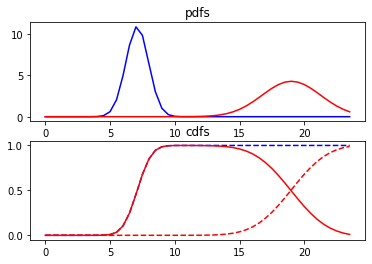

In [7]:
plot_model_tn(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],optimal_params_weekdaytn.x[3])

In [8]:
optimal_params_weekdayth=np.mean(optimal_params_weekdaytn.x[4:])

In [9]:
optimal_params_weekdayth

0.806567810682275

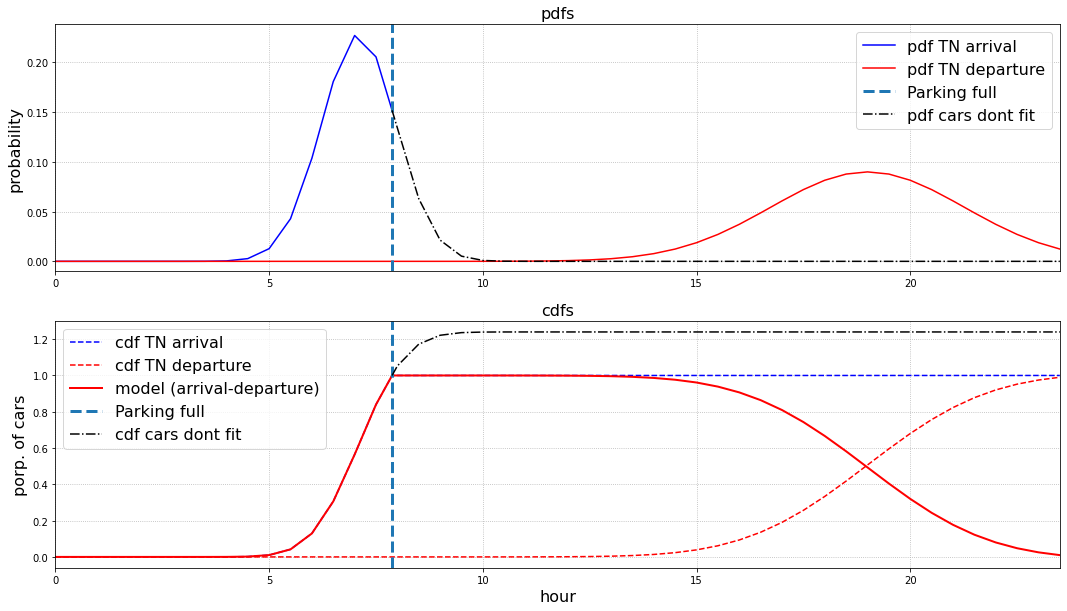

In [10]:
fid=plot_model_tn_thDisc(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],
              optimal_params_weekdaytn.x[3],optimal_params_weekdayth)
fid.savefig('Model_'+current_parking+'.pdf',bbox_inches='tight');

In [11]:
weekday_math_params = optimal_params_weekdaytn.x
weekday_math_params

array([0.295757  , 0.03638965, 0.79166579, 0.09411074, 0.79186614,
       0.91784199, 0.65629138, 1.02015911, 1.02648629, 0.92167831,
       0.76769668, 0.88661944, 0.90533556, 0.90984115, 0.73983651,
       0.89479434, 0.71671067, 0.76082157, 0.69406616, 0.80340711,
       0.74911726, 0.74911726, 0.74911679, 0.68829755, 1.06779299,
       0.70322416, 0.8828807 , 0.67706835, 0.55308513, 0.84168545,
       0.70249286])

In [12]:
time2 = np.linspace(0,23.5,48)
time_tn=time2/24
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#tn1_wd = gam(time2, optimal_params_weekday.x[0], optimal_params_weekday.x[1])
#tn2_wd = gam(time2, optimal_params_weekday.x[2], optimal_params_weekday.x[3])

#cdf1_wd_ap = generate_cdf(tn1_wd)
#cdf2_wd_ap = generate_cdf(tn2_wd)
cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
prototype_math_arr_weekday=cdf1_wd
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
prototype_math_dep_weekday=cdf2_wd
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd#/sum(resta_wd)

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time2, tn1_wd/sum(tn1_wd), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
#plt.plot(time2, cdf1_wd, label="Cummulative probability arrival")
#plt.plot(time2, cdf2_wd, label="Cummulative probability departure")
#plt.plot(time2, cdf1_wd_ap, label="Cummulative probability arrival approx")
#plt.plot(time2, cdf2_wd_ap, label="Cummulative probability departure approx")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");


In [13]:
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])

ix_parking_full= np.argmax(cdf1_wd>optimal_params_weekdayth)
t_parking_full=np.interp(optimal_params_weekdayth,cdf1_wd,time2)
time2_th=np.insert(time2,ix_parking_full,t_parking_full)

tn1_wd_unmodifed=tn1_wd
tn1_wd=np.insert(tn1_wd,ix_parking_full,np.interp(t_parking_full,time2,tn1_wd))
tn1_wd_excees=tn1_wd.copy()
tn1_wd[ix_parking_full+1:] =0
tn1_wd_excees[:ix_parking_full] =0
masktn1 = np.ones(len(tn1_wd), dtype=bool)
masktn1[ix_parking_full+1:] =False
masktn1_excees = np.ones(len(tn1_wd), dtype=bool)
masktn1_excees[:ix_parking_full] =False

#tn1_wd[cdf1_wd>optimal_params_weekdayth] =0
#tn1_wd_excees[cdf1_wd<optimal_params_weekdayth] =0
cdf1_wd[cdf1_wd>optimal_params_weekdayth] = optimal_params_weekdayth
cdf1_wd_plot=np.insert(cdf1_wd,ix_parking_full,optimal_params_weekdayth)

cdf1_wd = cdf1_wd/optimal_params_weekdayth
cdf1_wd_plot = cdf1_wd_plot/optimal_params_weekdayth

cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
cdf2_wd_plot=np.insert(cdf2_wd,ix_parking_full,np.interp(t_parking_full,time2,cdf2_wd))
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
resta_wd_plot = np.array(cdf1_wd_plot) - np.array(cdf2_wd_plot)
prototype_math_weekday = resta_wd#/sum(resta_wd)
prototype_math_weekday_plot = resta_wd_plot#/sum(resta_wd)
#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time2_th[masktn1], tn1_wd[masktn1]/sum(tn1_wd_unmodifed), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
#plt.plot(time2_th, cdf1_wd_plot, label="Cummulative probability arrival")
#plt.plot(time2_th, cdf2_wd_plot, label="Cummulative probability departure")

#plt.plot(t_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full")
#plt.plot(time2_th[masktn1_excees], tn1_wd_excees[masktn1_excees]/sum(tn1_wd_unmodifed),'-.',
#         label="Excess Probability")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");

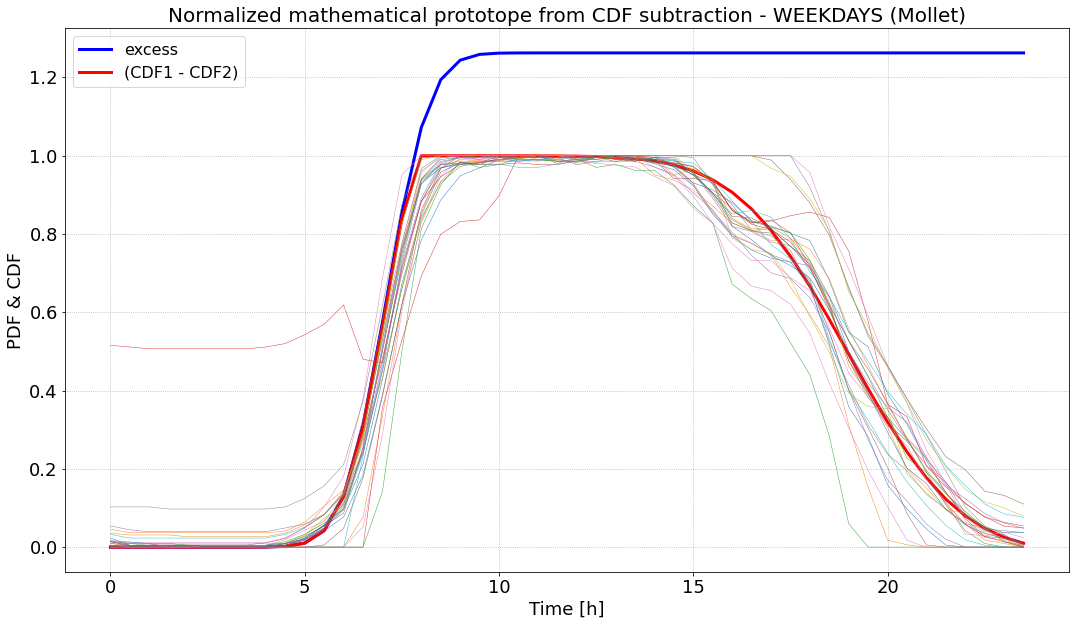

In [14]:
fig = plt.figure(figsize=(18,10))
plt.title("Normalized mathematical prototope from CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=20)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.plot(time2, prototype_math_arr_weekday/optimal_params_weekdaytn.x[4], linewidth=3, color='blue', label="excess")
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="(CDF1 - CDF2)")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    plt.plot(time, training_weekdays_norm[i], linewidth=0.45)

plt.legend(fontsize=16, loc="upper left");

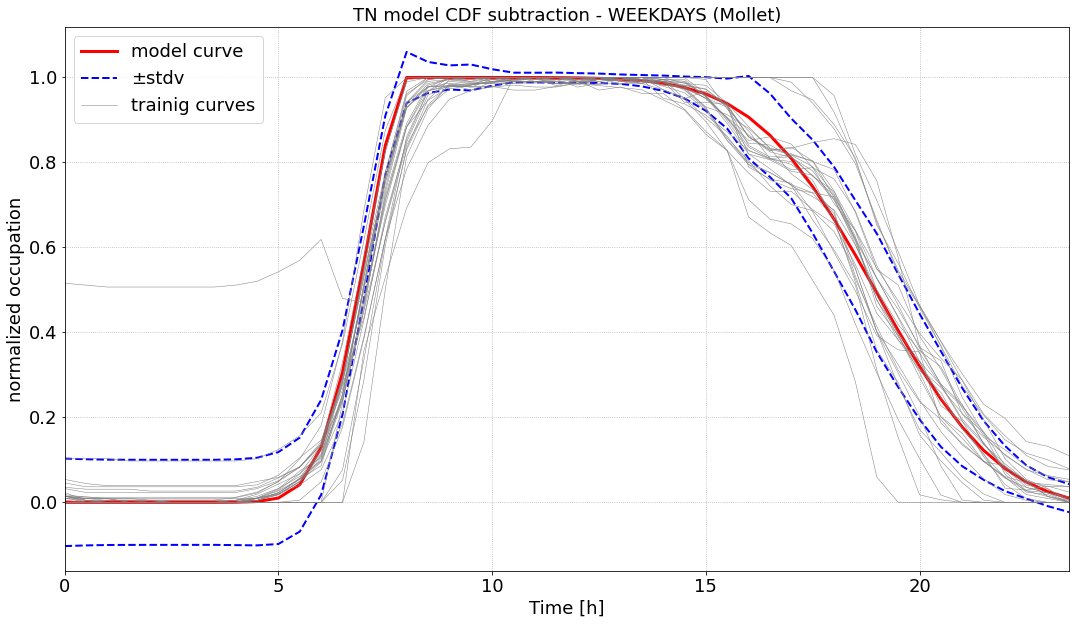

In [15]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekday-stdv_weekday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekday+stdv_weekday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    if i==0:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekdays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'.pdf',bbox_inches='tight');
fig.savefig('Training_'+current_parking+'.png',bbox_inches='tight');

In [16]:
bol_plot_individual_fits = False
if bol_plot_individual_fits: 
    tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
    tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

    cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])

    for ii in range(0,len(training_weekdays_norm)):
        idx_th=ii+4

        cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])


        dayisFull=training_weekdays_isfull[ii]
        if dayisFull:
            print(optimal_params_weekdaytn.x[idx_th])

            ix_parking_full= np.argmax(cdf1_wd>optimal_params_weekdaytn.x[idx_th])
            time_parking_full= 0.5*ix_parking_full
            str_parking_full= f'{int(time_parking_full):02.0f}:{int((time_parking_full-int(time_parking_full))*60):02.0f}h'

            print('Parking full        = '+str_parking_full)
            tn1_wd[cdf1_wd>optimal_params_weekdaytn.x[idx_th]] =0
            cdf1_wd[cdf1_wd>optimal_params_weekdaytn.x[idx_th]] = optimal_params_weekdaytn.x[idx_th]
            cdf1_wd = cdf1_wd/optimal_params_weekdaytn.x[idx_th]
        else:
            ix_parking_full=0
        resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
        prototype_math_weekday = resta_wd#/sum(resta_wd)
        fig = plt.figure(figsize=(18,10))
        fig.suptitle("Normalized mathematical prototope from CDF subtraction - weekdayS ("+current_parking+")", fontsize=20)
        if dayisFull:
            plt.plot(0.5*ix_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full "+str_parking_full)
        plt.grid(linestyle='dotted')
        plt.xlabel("Time [h]", fontsize=18)
        plt.ylabel("PDF & CDF", fontsize=18)
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.plot(time, prototype_math_weekday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
        #for i in range(0,len(training_weekdays_norm)):
        plt.plot(time, training_weekdays_norm[ii], linewidth=0.45)
        plt.legend(fontsize=16);

### FRIDAYS

In [17]:
if bolTrainagain:
    errors_fr = np.ones(np.shape(training_fridays_norm))

    parameters_tn_th_ind = np.array([.2 ,.05,.7,.1] + [.8]*f_length)
    optimal_params_fridaytn = minimize(model_tn_th_ind_max, 
                                    parameters_tn_th_ind, 
                                    args=(training_fridays_norm,training_fridays_isfull,errors_fr),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})



Optimization terminated successfully.
         Current function value: 6.431605
         Iterations: 1163
         Function evaluations: 1688


In [18]:
var_fridaytn = np.mean(errors_fr)
stdv_fridaytn=math.sqrt(var_fridaytn)
print('global stdv %.5f\n' % stdv_fridaytn)
stdv_friday30mins = np.sqrt(np.mean(errors_fr,0))
#print('stdv per time-step')
#for i in stdv_friday30mins:
#    print('\t' + str(i))

global stdv 0.14944



In [19]:
optimal_params_fridaytn

 final_simplex: (array([[0.30577551, 0.03871341, 0.81122301, 0.17153119, 0.88433931,
        0.75313584, 0.82026323, 0.54323612, 0.67382288, 0.67382288],
       [0.3057755 , 0.0387134 , 0.81122309, 0.17153123, 0.88433929,
        0.75313571, 0.82026281, 0.54323609, 0.67382311, 0.67382311],
       [0.30577551, 0.03871339, 0.81122308, 0.1715313 , 0.88433926,
        0.75313609, 0.82026298, 0.54323611, 0.67382275, 0.67382275],
       [0.30577549, 0.0387134 , 0.811223  , 0.17153121, 0.88433937,
        0.75313559, 0.82026271, 0.54323628, 0.67382346, 0.67382346],
       [0.30577552, 0.03871342, 0.81122294, 0.17153112, 0.88433933,
        0.75313566, 0.82026327, 0.54323615, 0.67382302, 0.67382302],
       [0.30577552, 0.03871341, 0.81122306, 0.17153129, 0.88433909,
        0.75313584, 0.82026253, 0.54323599, 0.67382296, 0.67382296],
       [0.30577551, 0.03871339, 0.81122307, 0.17153128, 0.88433925,
        0.75313582, 0.82026258, 0.54323615, 0.67382312, 0.67382312],
       [0.30577551, 0.03

In [20]:
#optimal_params_friday.x
#friday_math_params = optimal_params_friday.x
friday_math_params = optimal_params_fridaytn.x

In [21]:
optimal_params_fridaytn.x[4:]

array([0.88433931, 0.75313584, 0.82026323, 0.54323612, 0.67382288,
       0.67382288])

In [22]:
optimal_params_fridayth=np.mean(optimal_params_fridaytn.x[4:])

In [23]:

#tn1_fri = gam(time, optimal_params_friday.x[0], optimal_params_friday.x[1])
#tn2_fri = gam(time, optimal_params_friday.x[2], optimal_params_friday.x[3])
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
cdf1_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
cdf2_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

resta = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta#/sum(resta)
#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_fri, label="CDF Slot occupied")
#plt.plot(time, cdf2_fri, label="CDF Slot free")
#plt.plot(time, tn1_fri/sum(tn1_fri), label="Probability that a slot gets occupied")
#plt.plot(time, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")

#plt.legend(fontsize=16)

In [24]:
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

cdf1_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
prototype_math_arr_friday=cdf1_fri.copy()

ix_parking_full= np.argmax(cdf1_fri>optimal_params_fridayth)
t_parking_full=np.interp(optimal_params_fridayth,cdf1_fri,time2)
time2_th=np.insert(time2,ix_parking_full,t_parking_full)


tn1_fri_unmodifed=tn1_fri
tn1_fri=np.insert(tn1_fri,ix_parking_full,np.interp(t_parking_full,time2,tn1_fri))
tn1_fri_excees=tn1_fri.copy()
tn1_fri[ix_parking_full+1:] =0
tn1_fri_excees[:ix_parking_full] =0
masktn1 = np.ones(len(tn1_fri), dtype=bool)
masktn1[ix_parking_full+1:] =False
masktn1_excees = np.ones(len(tn1_fri), dtype=bool)
masktn1_excees[:ix_parking_full] =False

cdf1_fri[cdf1_fri>optimal_params_fridayth] = optimal_params_fridayth
cdf1_fri_plot=np.insert(cdf1_fri,ix_parking_full,optimal_params_fridayth)

cdf1_fri = cdf1_fri/optimal_params_fridayth
cdf1_fri_plot = cdf1_fri_plot/optimal_params_fridayth

cdf2_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])
cdf2_fri_plot=np.insert(cdf2_fri,ix_parking_full,np.interp(t_parking_full,time2,cdf2_fri))
prototype_math_dep_friday=cdf2_fri
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_fri = np.array(cdf1_fri) - np.array(cdf2_fri)
resta_fri_plot = np.array(cdf1_fri_plot) - np.array(cdf2_fri_plot)
prototype_math_friday = resta_fri#/sum(resta_wd)
prototype_math_friday_plot = resta_fri_plot

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

#fig = plt.figure(figsize=(18,10))
#plt.title("PDF and CDF for occupying and freeing a slot - FRIDAYS ("+current_parking+")", fontsize=20)

#plt.plot(time2_th[masktn1], tn1_fri[masktn1]/sum(tn1_fri_unmodifed), label="Probability that a slot gets occupied")
#plt.plot(time2, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
#plt.plot(time2_th, cdf1_fri_plot, label="Cummulative probability arrival")
#plt.plot(time2_th, cdf2_fri_plot, label="Cummulative probability departure")
#plt.plot(t_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full")
#plt.plot(time2_th[masktn1_excees], tn1_fri_excees[masktn1_excees]/sum(tn1_fri_unmodifed),'-.',
#         label="Excess Probability")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left");

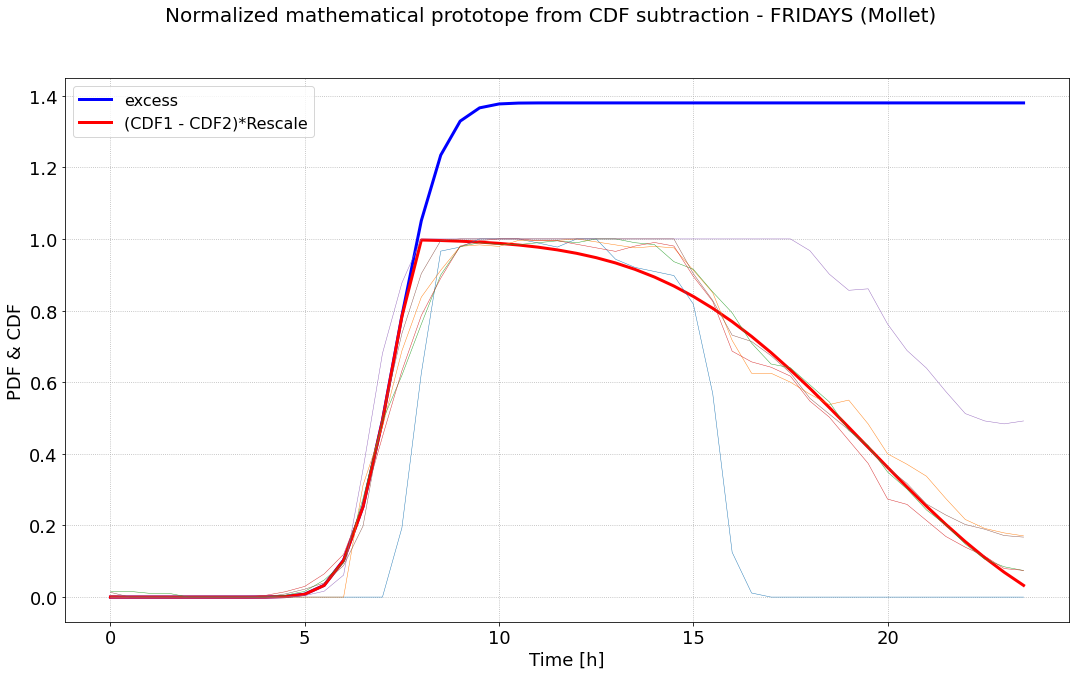

In [25]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Normalized mathematical prototope from CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=20)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.plot(time, prototype_math_arr_friday/optimal_params_fridayth, linewidth=3, color='blue', label="excess")
plt.plot(time, prototype_math_friday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
for i in range(0,len(training_fridays_norm)):
    plt.plot(time, training_fridays_norm[i], linewidth=0.45)
plt.legend(fontsize=16);

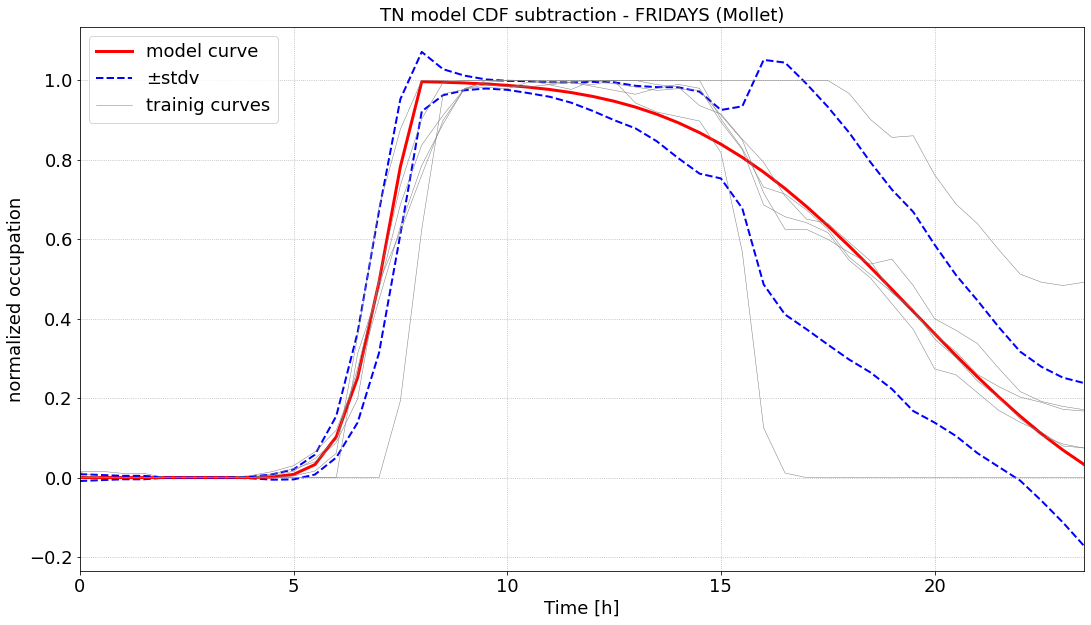

In [26]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_friday-stdv_friday30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_friday, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_friday+stdv_friday30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_fridays_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'_FRIDAY.pdf',bbox_inches='tight');

In [27]:
bol_plot_individual_fits = False
if bol_plot_individual_fits:
    tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
    tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

    cdf2_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

    for ii in range(0,len(training_fridays_norm)):
        idx_th=ii+4

        cdf1_fri = tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])


        dayisFull=training_fridays_isfull[ii]
        if dayisFull:
            print(optimal_params_fridaytn.x[idx_th])

            ix_parking_full= np.argmax(cdf1_fri>optimal_params_fridaytn.x[idx_th])
            time_parking_full= 0.5*ix_parking_full
            str_parking_full= f'{int(time_parking_full):02.0f}:{int((time_parking_full-int(time_parking_full))*60):02.0f}h'

            print('Parking full        = '+str_parking_full)
            tn1_fri[cdf1_fri>optimal_params_fridaytn.x[idx_th]] =0
            cdf1_fri[cdf1_fri>optimal_params_fridaytn.x[idx_th]] = optimal_params_fridaytn.x[idx_th]
            cdf1_fri = cdf1_fri/optimal_params_fridaytn.x[idx_th]
        else:
            ix_parking_full=0
        resta_fri = np.array(cdf1_fri) - np.array(cdf2_fri)
        prototype_math_friday = resta_fri#/sum(resta_fri)
        fig = plt.figure(figsize=(18,10))
        fig.suptitle("Normalized mathematical prototope from CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=20)
        if dayisFull:
            plt.plot(0.5*ix_parking_full*np.array([1, 1]),[0,1],'--',label="Parking full "+str_parking_full)
        plt.grid(linestyle='dotted')
        plt.xlabel("Time [h]", fontsize=18)
        plt.ylabel("PDF & CDF", fontsize=18)
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.plot(time, prototype_math_friday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
        #for i in range(0,len(training_fridays_norm)):
        plt.plot(time, training_fridays_norm[ii], linewidth=0.45)
        plt.legend(fontsize=16);

### WEEKENDS

In [28]:
parameters_tn = np.array([.2 ,.05,.7,.1])
if bolTrainagain:
    errors_we = np.ones(np.shape(training_weekends_norm))  
    if ((current_parking == "SantBoi") or (current_parking == "Cerdanyola")): 
        optimal_params_weekendtn = minimize(model_tn_max_args,
                                    parameters_tn, 
                                    args=(training_weekends_norm, errors_we),
                                    method='SLSQP',
                                    bounds=((0, None), (0, None),(0, None),(0, None)),
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})
    else:
        optimal_params_weekendtn = minimize(model_tn_max_args,
                                    parameters_tn, 
                                    args=(training_weekends_norm, errors_we),
                                    method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True, 'maxfev': 100000})


Optimization terminated successfully.
         Current function value: 12.735613
         Iterations: 6479
         Function evaluations: 10566


In [29]:
if bolTrainagain:
    #save modelparams and error
    with open('data/'+current_parking+'_modelFitTH.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we], f)
        f.close()
    
    # Getting back the objects:
    with open('data/'+current_parking+'_modelFitTH.pkl','rb') as f:  # Python 3: open(..., 'rb')
        [optimal_params_weekdaytn, errors_wd, optimal_params_fridaytn, 
                     errors_fr, optimal_params_weekendtn, errors_we]= pickle.load(f)
        f.close()

In [30]:
var_weekendtn = np.mean(errors_we)
stdv_weekendtn=math.sqrt(var_weekendtn)
print('global stdv %.5f\n' % stdv_weekendtn)
stdv_weekend30mins = np.sqrt(np.mean(errors_we,0))
#print('stdv per time-step')
#for i in stdv_weekend30mins:
#    print('\t' + str(i))

global stdv 0.17170



In [31]:
weekend_math_params = optimal_params_weekendtn.x
optimal_params_weekendtn.x

array([3.80635202e-01, 1.49301088e-01, 2.06314851e+04, 5.46645109e+01])

In [32]:
#tn1_we = gam(time, optimal_params_weekend.x[0], optimal_params_weekend.x[1])
#tn2_we = gam(time, optimal_params_weekend.x[2], optimal_params_weekend.x[3])
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



#cdf1_we = generate_cdf(tn1_we)
#cdf2_we = generate_cdf(tn2_we)
cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we#/sum(resta_we)
#fig = plt.figure(figsize=(18,10))
#fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKENDS ("+current_parking+")", fontsize=20)
#plt.plot(time, cdf1_we, label="CDF Slot occupied")
#plt.plot(time, cdf2_we, label="CDF Slot free")
#plt.plot(time, tn1_we/sum(tn1_we), label="Probability that a slot is occupied")
#plt.plot(time, tn2_we/sum(tn2_we),  label="Probability  a slot gets free")
#plt.grid(linestyle='dotted')
#plt.xlabel("Time [h]", fontsize=18)
#plt.ylabel("PDF & CDF", fontsize=18)
#plt.yticks(fontsize=18)
#plt.xticks(fontsize=18)
#plt.legend(fontsize=16, loc="upper left")

#plt.legend(fontsize=16)

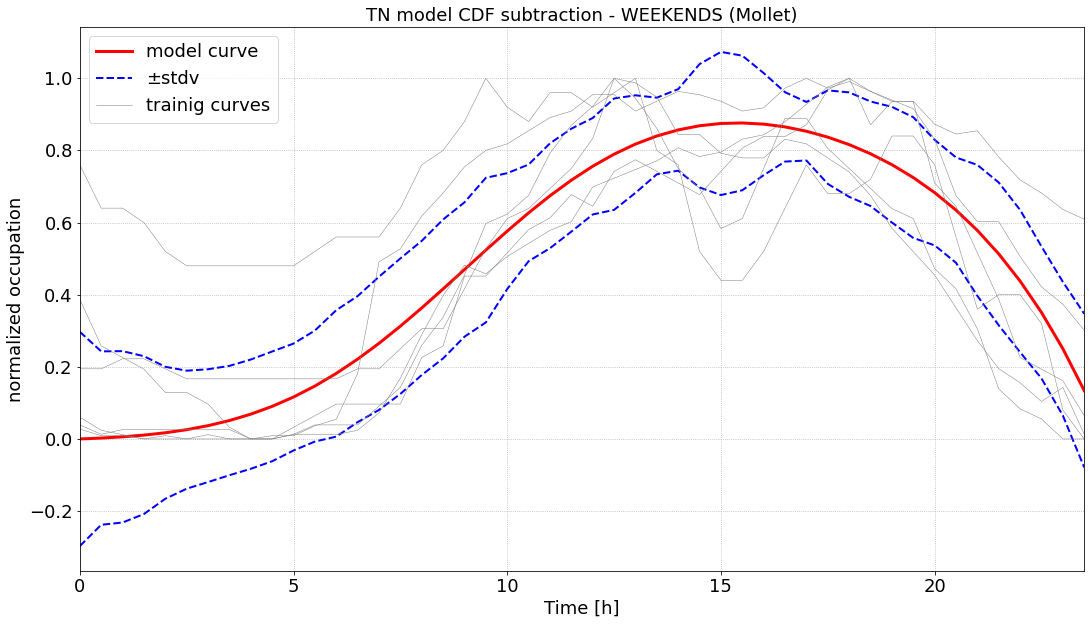

In [33]:
fsize=18
fig = plt.figure(figsize=(18,10))
plt.title("TN model CDF subtraction - WEEKENDS ("+current_parking+")", fontsize=fsize)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=fsize)
plt.ylabel("normalized occupation", fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.plot(time2, prototype_math_weekend-stdv_weekend30mins, linewidth=2, linestyle='--', color='blue')
plt.plot(time2, prototype_math_weekend, linewidth=3, color='red', label="model curve")
plt.plot(time2, prototype_math_weekend+stdv_weekend30mins, linewidth=2, linestyle='--', color='blue', label="±stdv")

for i in range(0,len(training_fridays_norm)):
    if i==0:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray', label="trainig curves")
    else:
        plt.plot(time, training_weekends_norm[i], linewidth=0.5, color='gray')

plt.xlim([0,23.5])
plt.legend(fontsize=fsize, loc="upper left");
fig.savefig('Training_'+current_parking+'WEEKEND.pdf',bbox_inches='tight');

In [34]:
printTimes(optimal_params_weekdaytn.x,current_parking,'WEEKDAYS')
printTimes(optimal_params_fridaytn.x,current_parking,'FRIDAYS')
printTimes(optimal_params_weekendtn.x,current_parking,'WEEKENDS')

--------- WEEKDAYS Mollet -----------
Mean Arrival Time   = 07:05h
stdv Arrival        =  0:52h
Mean Departure Time = 18:59h
stdv Departure      =  2:15h
Parking full        = 08:00h
--------- FRIDAYS Mollet -----------
Mean Arrival Time   = 07:20h
stdv Arrival        =  0:55h
Mean Departure Time = 19:28h
stdv Departure      =  4:07h
Parking full        = 08:00h
--------- WEEKENDS Mollet -----------
Mean Arrival Time   = 09:08h
stdv Arrival        =  3:34h
Mean Departure Time = 495155:38h
stdv Departure      = 1311:56h


In [35]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

tn_arr_weekday_n = prototype_math_arr_weekday
tn_dep_weekday_n = prototype_math_dep_weekday
tn_arr_friday_n = prototype_math_arr_friday
tn_dep_friday_n = prototype_math_dep_friday

### Comparing normalized mathematical fitted prototype with testing data

### Denormalization / Rescaling

In [36]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_max + weekday_offset
tn_arr_weekday = tn_arr_weekday_n*weekday_max + weekday_offset

tn_weekday_nooff = tn_weekday_n*weekday_max 
tn_arr_weekday_nooff = tn_arr_weekday_n*weekday_max 
tn_dep_weekday = tn_dep_weekday_n*weekday_max #+ weekday_offset

#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_max + friday_offset
tn_arr_friday = tn_arr_friday_n*friday_max + friday_offset

tn_friday_nooff = tn_friday_n*friday_max
tn_arr_friday_nooff = tn_arr_friday_n*friday_max
tn_dep_friday = tn_dep_friday_n*friday_max #+ friday_offset

#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_max + weekend_offset 

tn1_weekend_nooff = tn1_weekend_n*weekend_max 

In [37]:
with open('data/'+current_parking+'_testing.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [testing_mondays, testing_mondays_dates, testing_tuesdays, testing_tuesdays_dates, 
    testing_wednesdays, testing_wednesdays_dates, testing_thursdays, testing_thursdays_dates, 
    testing_fridays, testing_fridays_dates, testing_saturdays, testing_saturdays_dates,
    testing_sundays, testing_sundays_dates]= pickle.load(f)
    f.close()  
  

______ MEAN ± STDV________
10.719374657268899  ±  3.2727904295598313
9.291063814782499  ±  4.0262447735856135
8.22119474945938  ±  3.34829848274315
7.884570927046731  ±  3.1279515903837347
14.552459136425329  ±  6.231671353370113
12.600109327528065  ±  11.525758297188553
13.681189488643943  ±  10.182147726568259


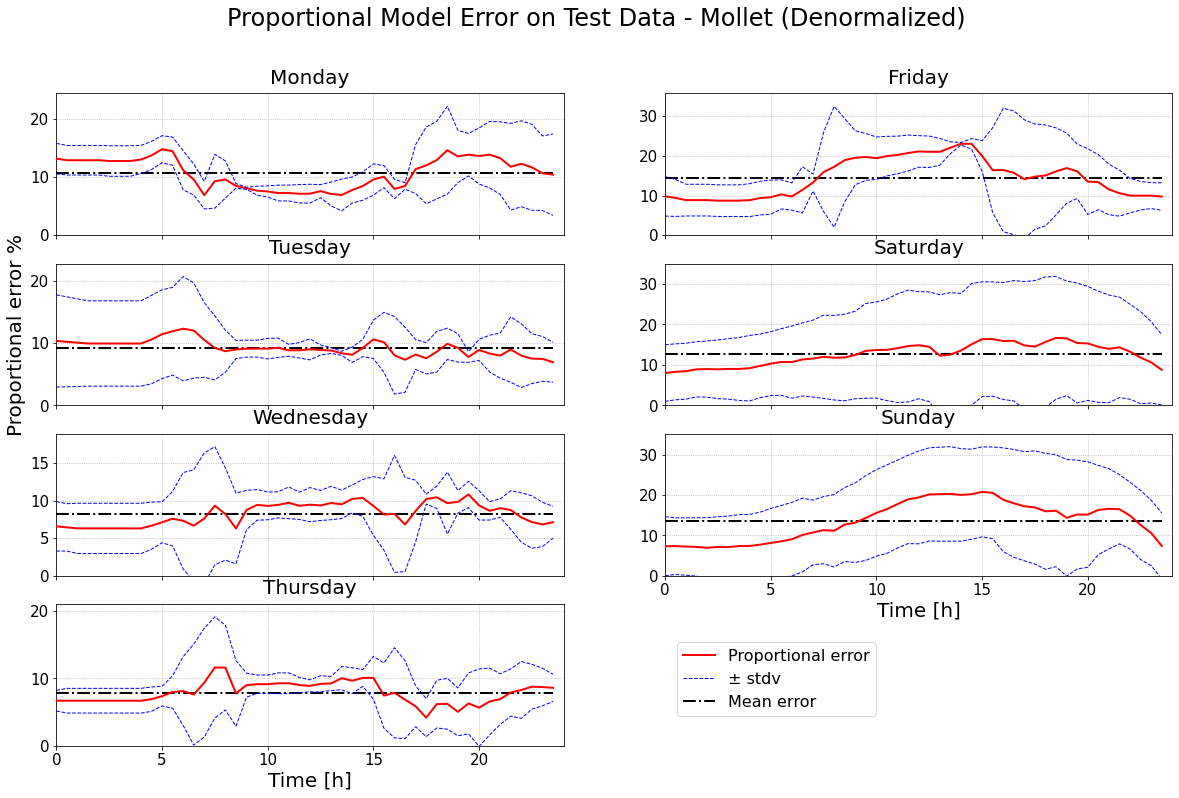

In [38]:


[error_monday_tn,stdv_error_monday_tn] = compute_testing_prop_errorMstdv(testing_mondays, tn_weekday, max_value)
[error_tuesday_tn,stdv_error_tuesday_tn] = compute_testing_prop_errorMstdv(testing_tuesdays, tn_weekday, max_value)
[error_wednesday_tn,stdv_error_wednesday_tn] = compute_testing_prop_errorMstdv(testing_wednesdays, tn_weekday, max_value)
[error_thursday_tn,stdv_error_thursday_tn] = compute_testing_prop_errorMstdv(testing_thursdays, tn_weekday, max_value)
[error_friday_tn,stdv_error_friday_tn] = compute_testing_prop_errorMstdv(testing_fridays, tn_friday, max_value)
[error_saturday_tn,stdv_error_saturday_tn] = compute_testing_prop_errorMstdv(testing_saturdays, tn1_weekend, max_value)
[error_sunday_tn,stdv_error_sunday_tn] = compute_testing_prop_errorMstdv(testing_sundays, tn1_weekend, max_value)



    
fig, ax = plt.subplots(4, 2)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Proportional Model Error on Test Data - '+current_parking+' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_tn)]*len(time)
mstdv_Monday= np.mean(stdv_error_monday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 0, 0, time, error_monday_tn, stdv_error_monday_tn, mean_Monday, 
                 'Monday', 'Monday',False,False,False,False)

mean_Tuesday =  [np.mean(error_tuesday_tn)]*len(time)
mstdv_Tuesday= np.mean(stdv_error_tuesday_tn[~np.isnan(stdv_error_tuesday_tn)])
subplotCDFsubtractionStdvErr(fig, ax, 1, 0, time, error_tuesday_tn, stdv_error_tuesday_tn,  mean_Tuesday, 
                 'Tuesday', 'Tuesday',False,True,False,False)

mean_Wednesday =  [np.mean(error_wednesday_tn)]*len(time)
mstdv_Wednesday= np.mean(stdv_error_wednesday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 2, 0, time, error_wednesday_tn, stdv_error_wednesday_tn, mean_Wednesday, 
                 'Wednesday', 'Wednesday',False,False,False,False)

mean_Thursday =  [np.mean(error_thursday_tn)]*len(time)
mstdv_Thursday= np.mean(stdv_error_thursday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 3, 0, time, error_thursday_tn, stdv_error_thursday_tn, mean_Thursday, 
                 'Thursday', 'Thursday',True,False,True,False)

mean_Friday =  [np.mean(error_friday_tn)]*len(time)
mstdv_Friday= np.mean(stdv_error_friday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 0, 1, time, error_friday_tn, stdv_error_friday_tn, mean_Friday, 
                 'Friday', 'Friday',False,False,False,False)

mean_Saturday =  [np.mean(error_saturday_tn)]*len(time)
mstdv_Saturday= np.mean(stdv_error_saturday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 1, 1, time, error_saturday_tn, stdv_error_saturday_tn, mean_Saturday, 
                 'Saturday', 'Saturday',False,False,False,False)

mean_Sunday =  [np.mean(error_sunday_tn)]*len(time)
mstdv_Sunday= np.mean(stdv_error_sunday_tn)
subplotCDFsubtractionStdvErr(fig, ax, 2, 1, time, error_sunday_tn, stdv_error_sunday_tn, mean_Sunday, 
                 'Sunday', 'Sunday',True,False,True,True)

ax[3,1].set_visible(False)
fig.savefig('TestError_'+current_parking+'th.pdf',bbox_inches='tight');
#ax[1,1].set_visible(False)
#fig.tight_layout(pad=5.0)
#for ax in ax.flat:
#    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
#    ax.set_xlabel('HOUR', fontsize=11)


print('______ MEAN ± STDV________')    

print( mean_Monday[0], ' ± ', mstdv_Monday)
print(mean_Tuesday[0], ' ± ', mstdv_Tuesday)
print(mean_Wednesday[0], ' ± ', mstdv_Wednesday)
print(mean_Thursday[0], ' ± ', mstdv_Thursday)
print(mean_Friday[0], ' ± ', mstdv_Friday)
print(mean_Saturday[0], ' ± ', mstdv_Saturday)
print(mean_Sunday[0], ' ± ', mstdv_Sunday)
#print('______STDV________')

#print(np.std(error_monday_tn))
#print(np.std(error_tuesday_tn))
#print(np.std(error_wednesday_tn))
#print(np.std(error_thursday_tn))
#print(np.std(error_friday_tn))
#print(np.std(error_saturday_tn))
#print(np.std(error_sunday_tn))


In [39]:
m_row=[current_parking,'meanE',mean_Monday[0], mean_Tuesday[0], mean_Wednesday[0], mean_Thursday[0],
       mean_Friday[0],mean_Saturday[0], mean_Sunday[0]]
s_row=[current_parking,'mStdvE',mstdv_Monday, mstdv_Tuesday, mstdv_Wednesday,  mstdv_Thursday, 
       mstdv_Friday, mstdv_Saturday, mstdv_Sunday]

In [40]:
f = open('data/'+current_parking+'_testErrorTH.csv', 'w')
# create the csv writer
writer = csv.writer(f)

# write a row to the csv file
writer.writerow(m_row)
writer.writerow(s_row)

# close the file
f.close()

### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [41]:
with open('data/'+current_parking+'_proto.pkl','rb') as f:  # Python 3: open(..., 'rb')
    [hist_weekday_proto, hist_friday_proto, hist_weekend_proto]= pickle.load(f)
    f.close() 

In [42]:
def plot_prototype_fit():
    for i in range(0,len(tn_proto)):
        if tn_proto[i] < 0:
            tn_proto[i] = 0
    cont=0
    for i in range(0,len(t_days)):
        t_date=t_dates[cont]
        print(t_date)
        #tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
        tn_arr_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_arr_proto)
        stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)

        #scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
        scaled_tn_arr_proto = tn_arr_proto * tn_arr_scaling.x[1]+tn_arr_scaling.x[0]
        scaled_tn_dep_proto = tn_dep_proto * tn_arr_scaling.x[1]
        
    
        if max(scaled_tn_arr_proto)>max_value:
            cars_could_not_park=max(scaled_tn_arr_proto[scaled_tn_arr_proto >max_value])-max_value
            print(round(cars_could_not_park), "cars could not park")
            scaled_tn_arr_proto[scaled_tn_arr_proto >max_value]=max_value
            scaled_tn_dep_proto=scaled_tn_dep_proto/max(scaled_tn_dep_proto)*(max_value-tn_arr_scaling.x[0])
        
        scaled_tn_proto2=scaled_tn_arr_proto-scaled_tn_dep_proto

        scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
        fig, ax = plt.subplots(1, 2)
        fig.set_figwidth(20)
        fig.set_figheight(5)
        axx=0;
        real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                              scaled_tn_proto2, scaled_stat_proto, limit_hour, t_date, current_parking)
        axx=1;
        errors_plottingM(fig, ax, axx, scaled_tn_proto2, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
        cont=cont+1

In [43]:
def plot_prototype_fitTH():
    for i in range(0,len(tn_proto)):
        if tn_proto[i] < 0:
            tn_proto[i] = 0
    cont=0
    for i in range(0,len(t_days)):
        t_date=t_dates[cont]
        print(t_date)
        #tn_scaling = get_scaling_factor_and_constantTH(limit_hour, t_days[i], tn_proto, max_value)
        tn_arr_scaling = get_scaling_factor_and_constantTH(limit_hour, t_days[i], tn_arr_proto)
        stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)

        #scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
        scaled_tn_arr_proto = tn_arr_proto * tn_arr_scaling.x[1]+tn_arr_scaling.x[0]
        scaled_tn_dep_proto = tn_dep_proto * tn_arr_scaling.x[1]
        
    
        if max(scaled_tn_arr_proto)>max_value:
            cars_could_not_park=max(scaled_tn_arr_proto[scaled_tn_arr_proto >max_value])-max_value
            print(round(cars_could_not_park), "cars could not park")
            scaled_tn_arr_proto[scaled_tn_arr_proto >max_value]=max_value
            scaled_tn_dep_proto=scaled_tn_dep_proto/max(scaled_tn_dep_proto)*(max_value-tn_arr_scaling.x[0])
        
        scaled_tn_proto2=scaled_tn_arr_proto-scaled_tn_dep_proto

        scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
        fig, ax = plt.subplots(1, 2)
        fig.set_figwidth(20)
        fig.set_figheight(5)
        axx=0;
        real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                              scaled_tn_proto2, scaled_stat_proto, limit_hour, t_date, current_parking)
        axx=1;
        errors_plottingM(fig, ax, axx, scaled_tn_proto2, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
        cont=cont+1

#### MONDAY

In [44]:
statistic_proto = hist_weekday_proto
t_days = testing_mondays
t_dates=testing_mondays_dates
limit_hour = 17
day = 'Monday'

2020-02-24
Real Monday scaled prtotype error:  17.95 %
Real Monday scaled prtotype STDV:  7.6774328606459274
Real Monday scaled TN error:  19.02 %
Real Monday scaled TN STDV:  8.940349458502038
_____________________________________________________________
2020-03-02
35 cars could not park
Real Monday scaled prtotype error:  3.47 %
Real Monday scaled prtotype STDV:  2.528200605085632
Real Monday scaled TN error:  4.67 %
Real Monday scaled TN STDV:  2.4164571657227447
_____________________________________________________________
2020-03-09
30 cars could not park
Real Monday scaled prtotype error:  10.16 %
Real Monday scaled prtotype STDV:  2.0455309438158484
Real Monday scaled TN error:  10.54 %
Real Monday scaled TN STDV:  1.7241139619056
_____________________________________________________________


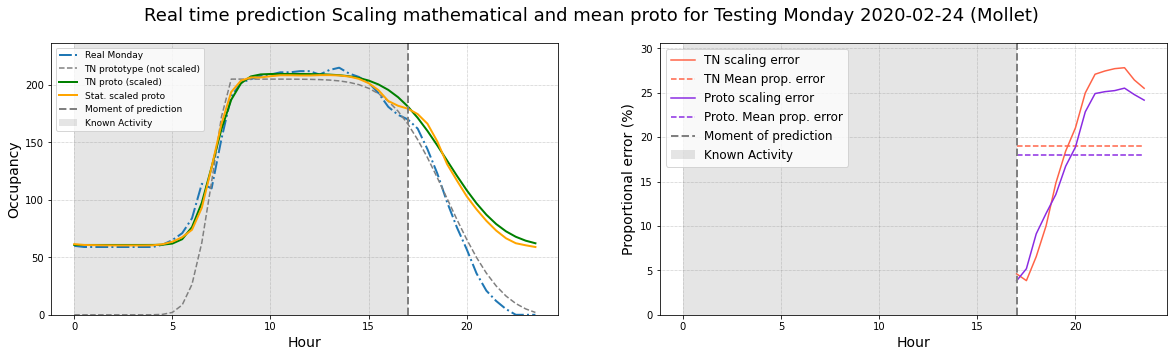

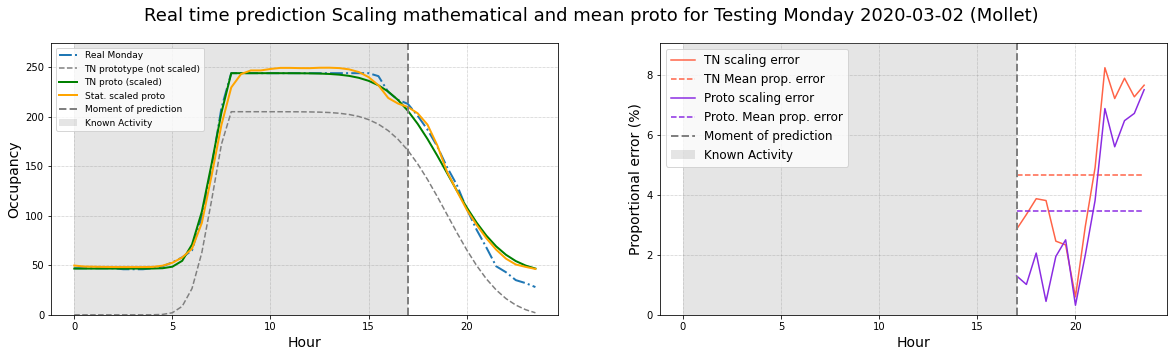

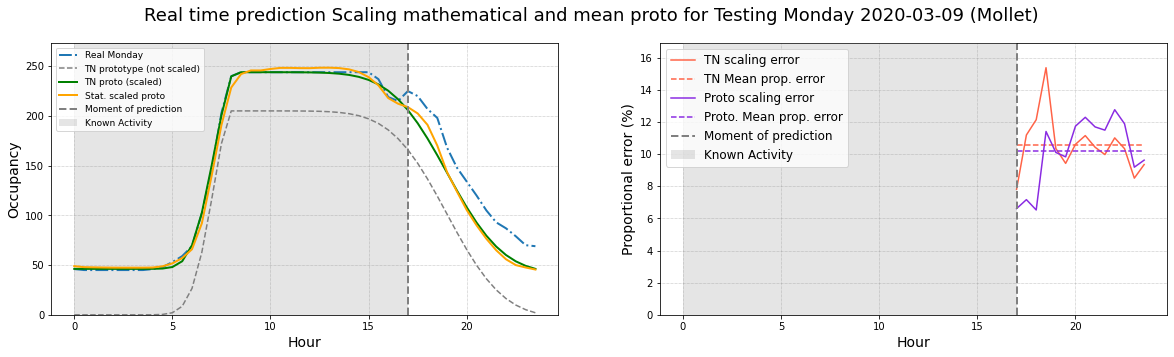

In [45]:
tn_proto = tn_weekday_nooff

tn_arr_proto = tn_arr_weekday_nooff
tn_dep_proto = tn_dep_weekday
plot_prototype_fitTH()

In [46]:
starting_hour=7

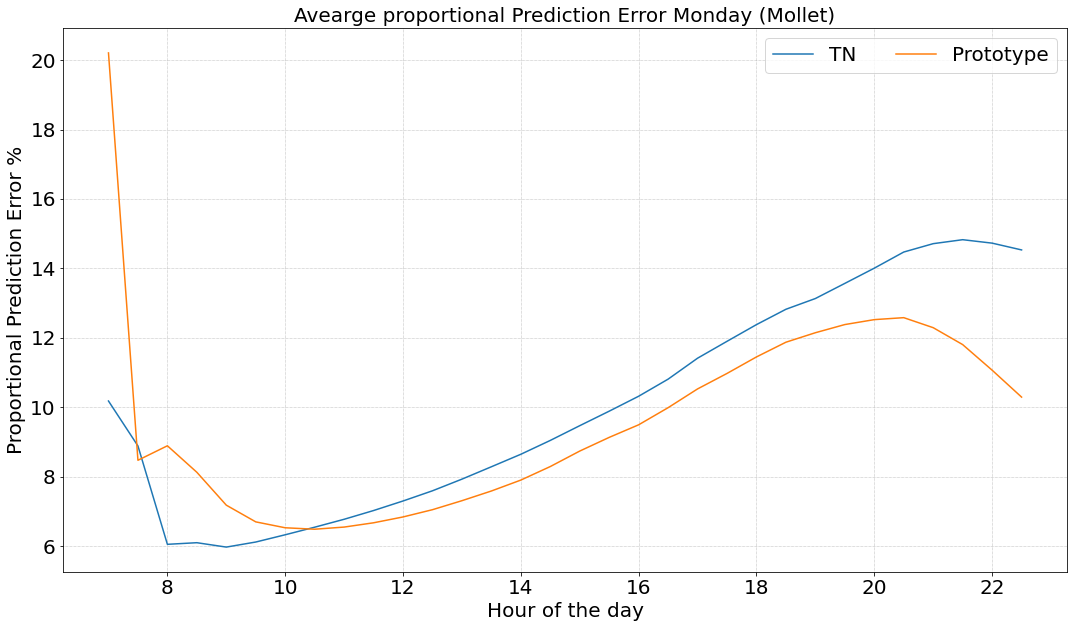

In [47]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [48]:
proto_running_error_wd=proto_running_error_vec
tn_running_error_wd=tn_running_error_vec

#### TUESDAY

In [49]:
statistic_proto = hist_weekday_proto
t_days = testing_tuesdays
t_dates= testing_tuesdays_dates
limit_hour = 8
day = 'Tuesday'

2020-02-25
Real Tuesday scaled prtotype error:  3.99 %
Real Tuesday scaled prtotype STDV:  2.31547831911705
Real Tuesday scaled TN error:  2.6 %
Real Tuesday scaled TN STDV:  2.2495493726831923
_____________________________________________________________
2020-03-03
30 cars could not park
Real Tuesday scaled prtotype error:  7.58 %
Real Tuesday scaled prtotype STDV:  4.492022547815544
Real Tuesday scaled TN error:  1.23 %
Real Tuesday scaled TN STDV:  1.659577645230145
_____________________________________________________________
2020-03-10
45 cars could not park
Real Tuesday scaled prtotype error:  12.17 %
Real Tuesday scaled prtotype STDV:  2.802505382551961
Real Tuesday scaled TN error:  3.0 %
Real Tuesday scaled TN STDV:  3.6747503457655153
_____________________________________________________________


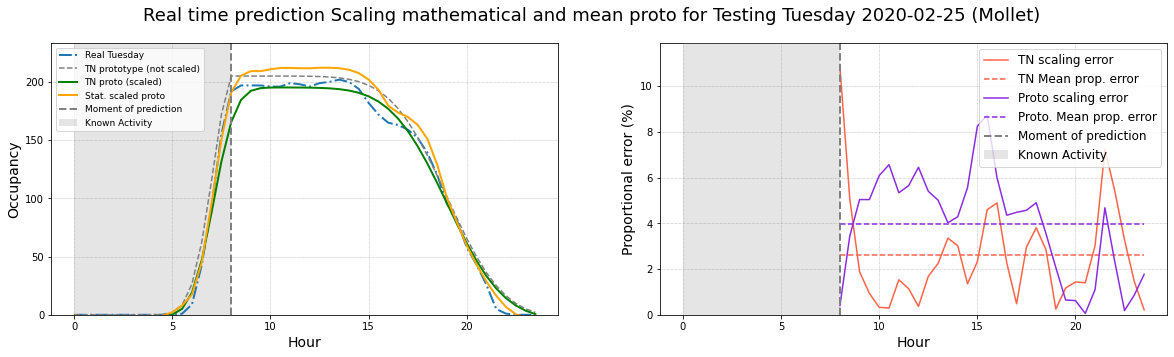

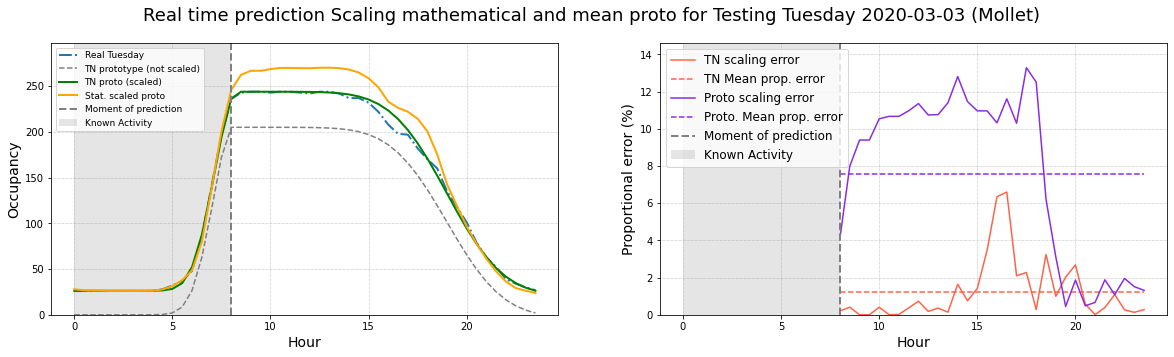

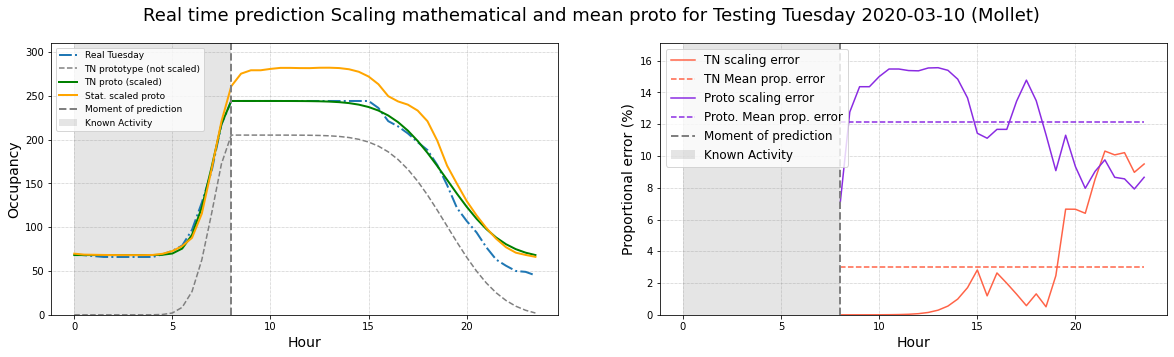

In [50]:
tn_proto = tn_weekday_nooff

tn_arr_proto = tn_arr_weekday_nooff
tn_dep_proto = tn_dep_weekday
plot_prototype_fitTH()

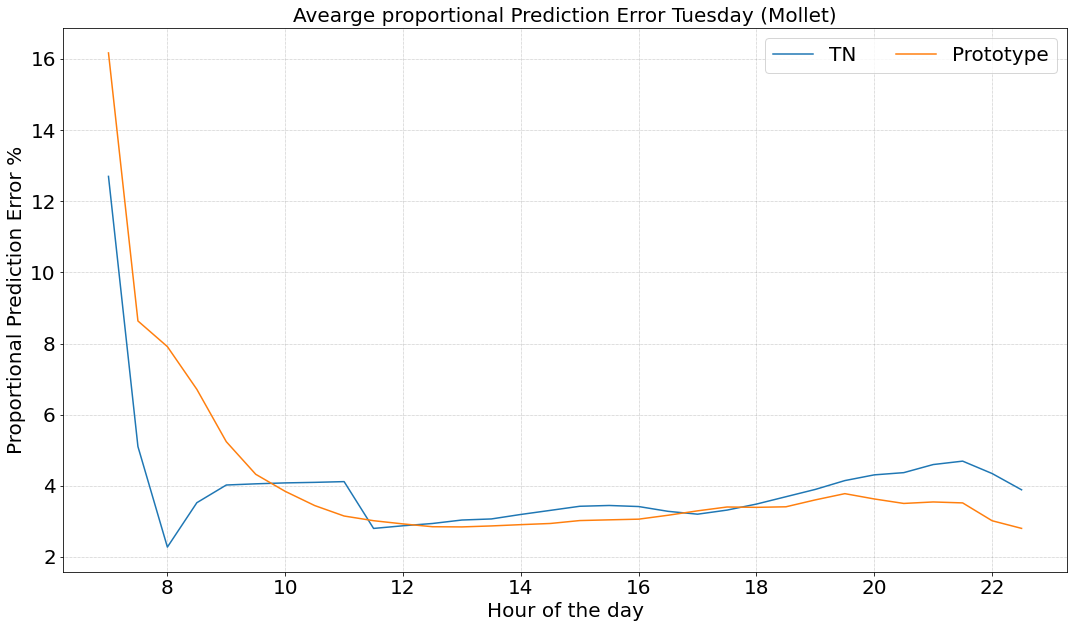

In [51]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [52]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

### WEDNESDAY

In [53]:
statistic_proto = hist_weekday_proto
t_days = testing_wednesdays
t_dates= testing_wednesdays_dates
limit_hour = 15
day = 'Wednesday'

2020-02-26
Real Wednesday scaled prtotype error:  1.95 %
Real Wednesday scaled prtotype STDV:  1.2203294553068826
Real Wednesday scaled TN error:  2.94 %
Real Wednesday scaled TN STDV:  2.7767754490511374
_____________________________________________________________
2020-03-04
13 cars could not park
Real Wednesday scaled prtotype error:  5.71 %
Real Wednesday scaled prtotype STDV:  3.68118469449911
Real Wednesday scaled TN error:  5.93 %
Real Wednesday scaled TN STDV:  2.2861859348315607
_____________________________________________________________
2020-03-11
Real Wednesday scaled prtotype error:  1.72 %
Real Wednesday scaled prtotype STDV:  1.2489819228995651
Real Wednesday scaled TN error:  2.81 %
Real Wednesday scaled TN STDV:  2.0280364933666695
_____________________________________________________________


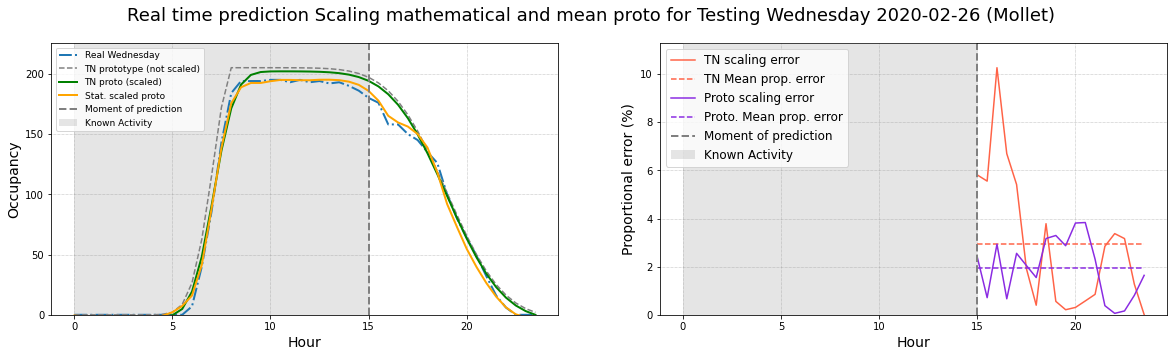

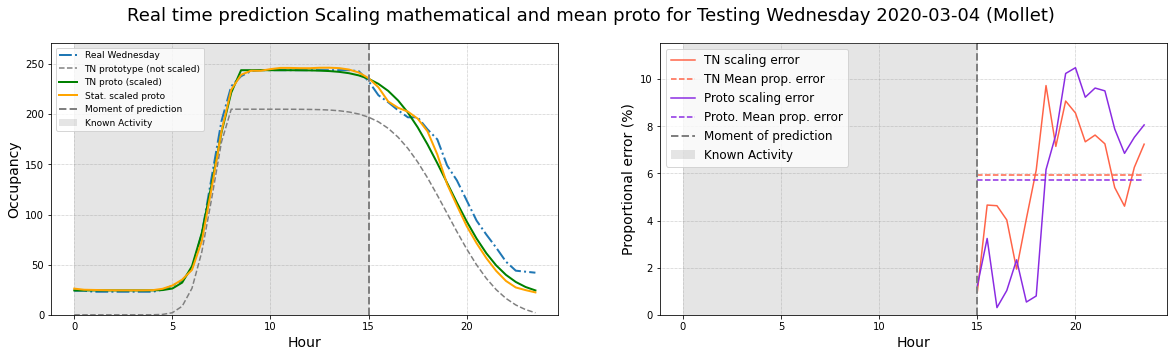

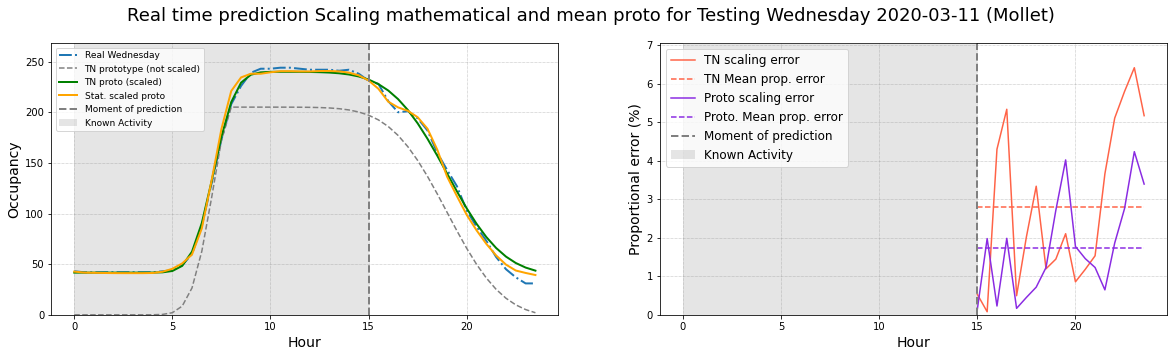

In [54]:
tn_proto = tn_weekday_nooff

tn_arr_proto = tn_arr_weekday_nooff
tn_dep_proto = tn_dep_weekday
plot_prototype_fitTH()

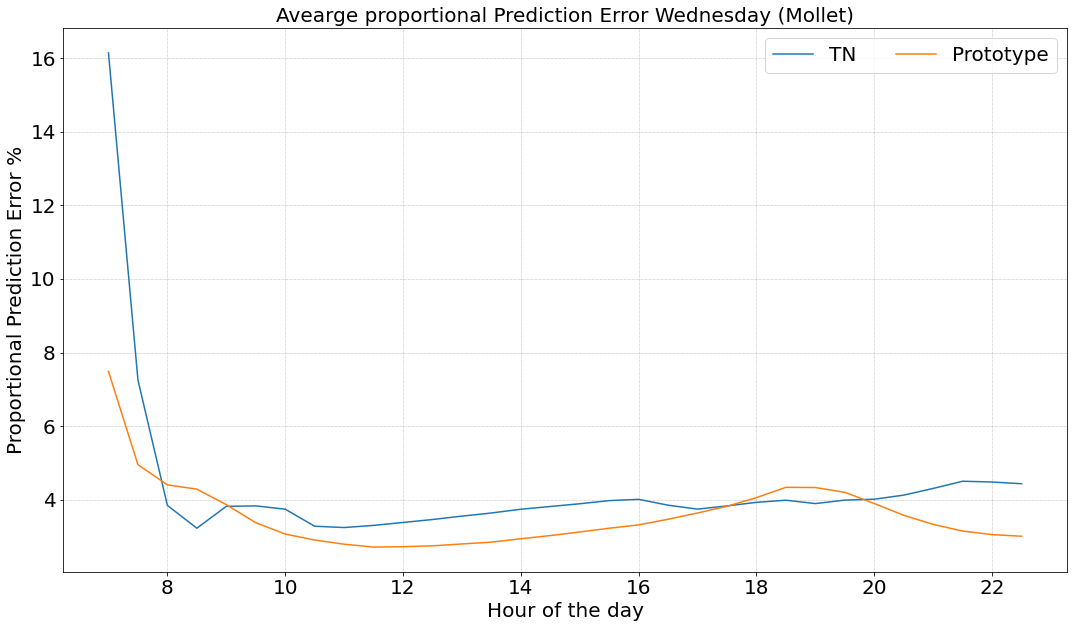

In [55]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [56]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

### THURSDAY

In [57]:
statistic_proto = hist_weekday_proto
t_days = testing_thursdays
t_dates= testing_thursdays_dates
limit_hour = 8
day = 'Thursday'

2020-02-27
Real Thursday scaled prtotype error:  3.78 %
Real Thursday scaled prtotype STDV:  2.253083251927413
Real Thursday scaled TN error:  6.88 %
Real Thursday scaled TN STDV:  3.2247486383921165
_____________________________________________________________
2020-03-05
20 cars could not park
Real Thursday scaled prtotype error:  8.18 %
Real Thursday scaled prtotype STDV:  3.0086385643716196
Real Thursday scaled TN error:  2.71 %
Real Thursday scaled TN STDV:  2.5721428786463965
_____________________________________________________________
2020-03-12
Real Thursday scaled prtotype error:  3.45 %
Real Thursday scaled prtotype STDV:  1.6090372735206877
Real Thursday scaled TN error:  3.06 %
Real Thursday scaled TN STDV:  2.5243858753898354
_____________________________________________________________


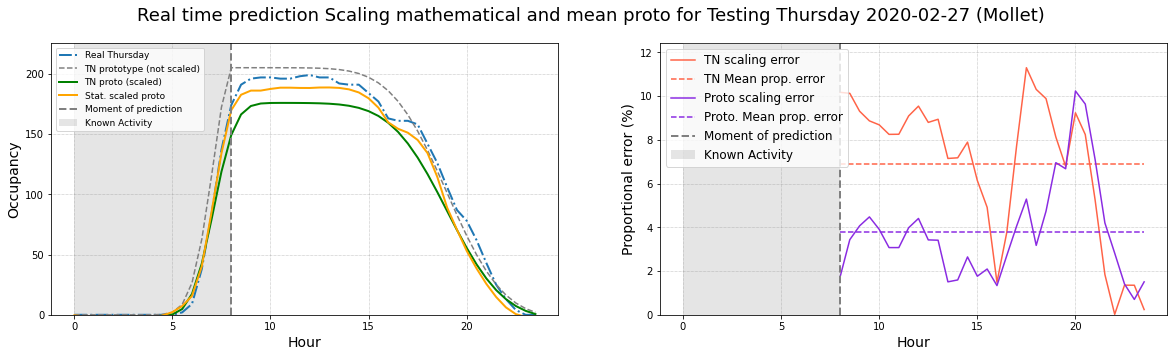

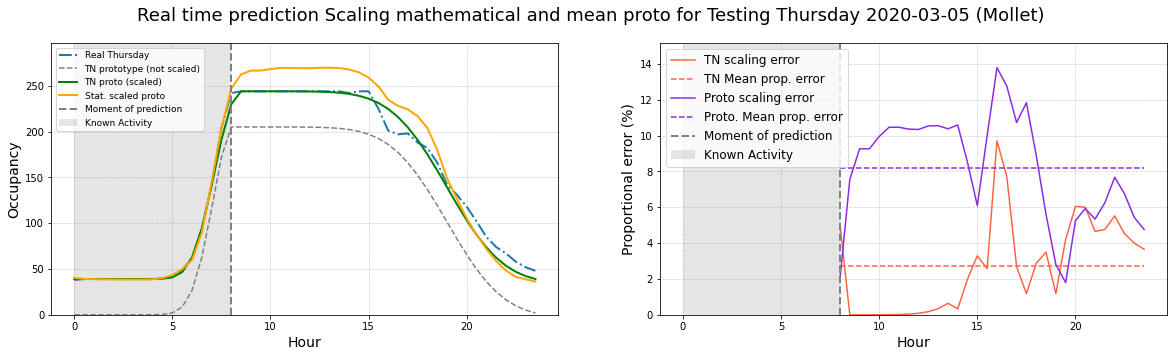

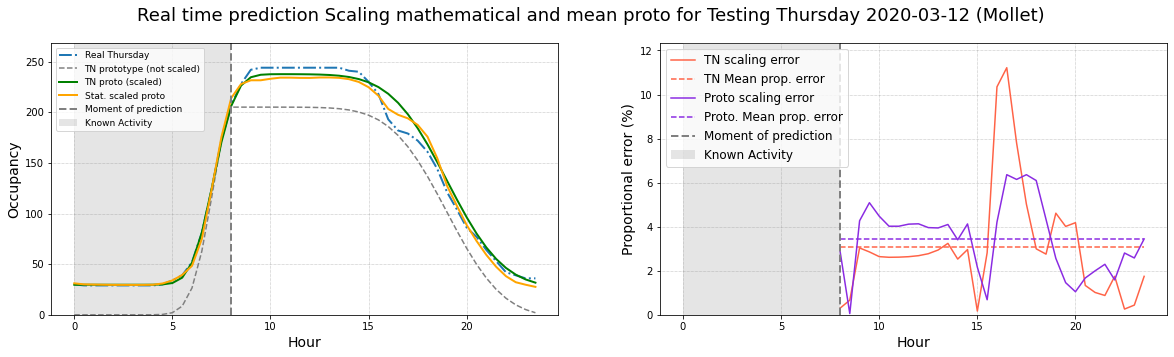

In [58]:
tn_proto = tn_weekday_nooff

tn_arr_proto = tn_arr_weekday_nooff
tn_dep_proto = tn_dep_weekday
plot_prototype_fitTH()

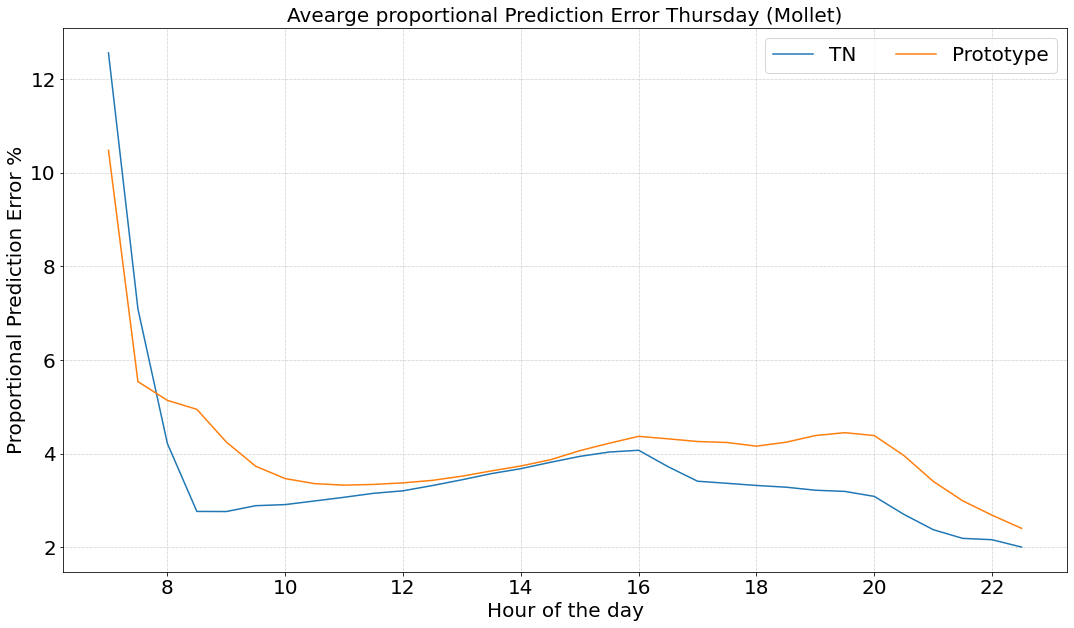

In [59]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [60]:
proto_running_error_wd=np.concatenate((proto_running_error_wd, proto_running_error_vec), axis=1)
tn_running_error_wd=np.concatenate((tn_running_error_wd, tn_running_error_vec), axis=1)

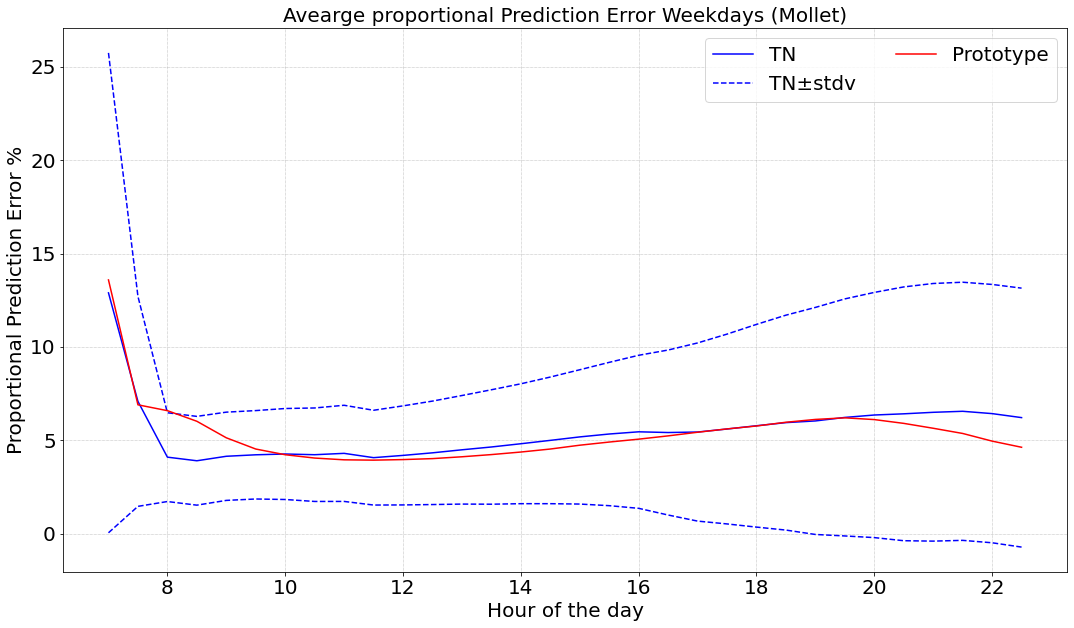

In [61]:
figH=plotRunningPredcitionErrorSTDV(tn_running_error_wd,proto_running_error_wd,starting_hour,"Weekdays",current_parking)

### FRIDAY

In [62]:
statistic_proto = hist_friday_proto
t_days = testing_fridays
t_dates=testing_fridays_dates
limit_hour = 16
day = 'Friday'

2020-02-28
20 cars could not park
Real Friday scaled prtotype error:  2.15 %
Real Friday scaled prtotype STDV:  0.9762827476990465
Real Friday scaled TN error:  9.07 %
Real Friday scaled TN STDV:  5.49591570580676
_____________________________________________________________
2020-03-06
29 cars could not park
Real Friday scaled prtotype error:  14.46 %
Real Friday scaled prtotype STDV:  2.415245290843113
Real Friday scaled TN error:  9.31 %
Real Friday scaled TN STDV:  3.919140343994685
_____________________________________________________________
2020-03-13
Real Friday scaled prtotype error:  19.88 %
Real Friday scaled prtotype STDV:  2.174794971353397
Real Friday scaled TN error:  19.06 %
Real Friday scaled TN STDV:  1.5241845517627335
_____________________________________________________________


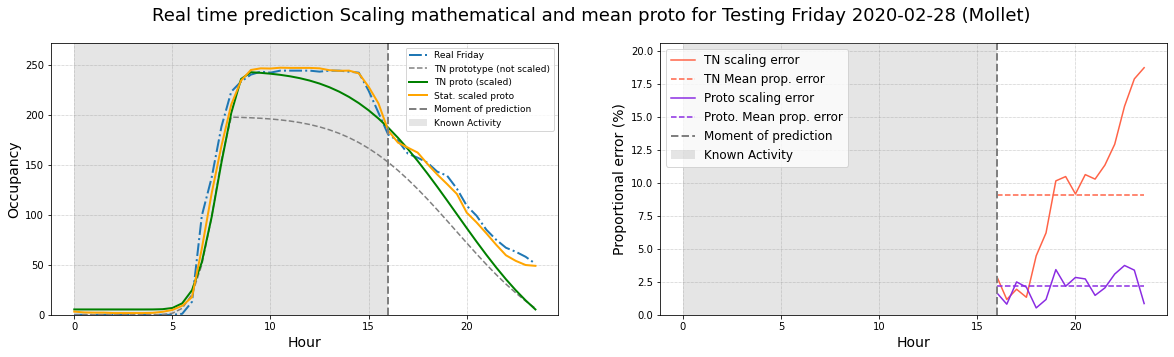

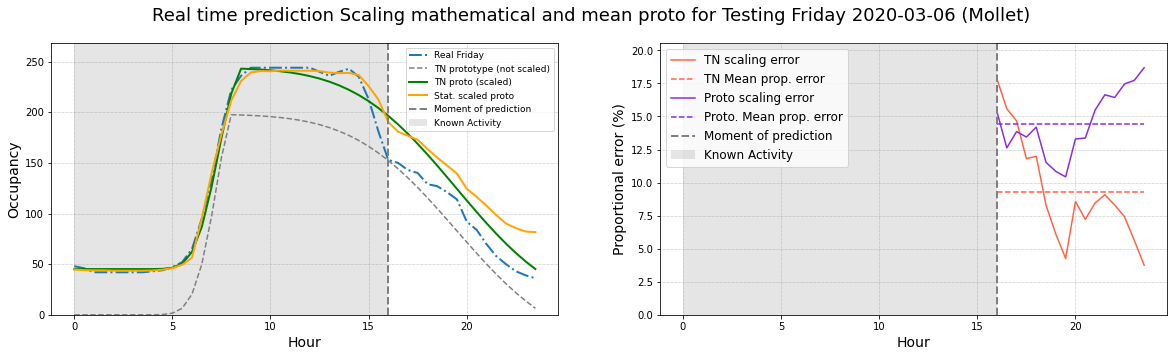

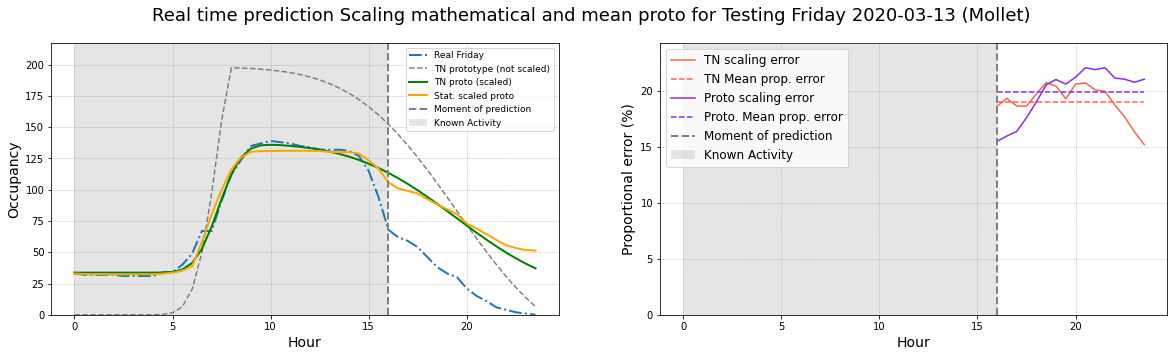

In [63]:
tn_proto = tn_friday_nooff

tn_arr_proto = tn_arr_friday_nooff
tn_dep_proto = tn_dep_friday
plot_prototype_fitTH()

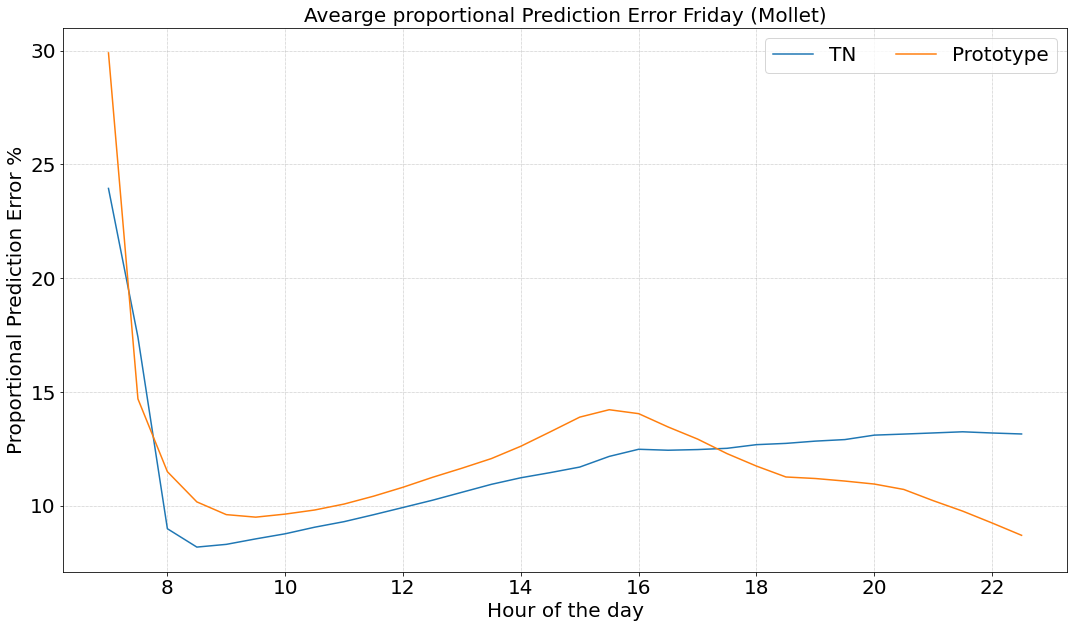

In [64]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionErrorTHv2(t_days,hist_weekday_proto,
                                                                            tn_arr_proto,tn_dep_proto,
                                                                            max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [65]:
proto_running_error_fr=proto_running_error_vec
tn_running_error_fr=tn_running_error_vec

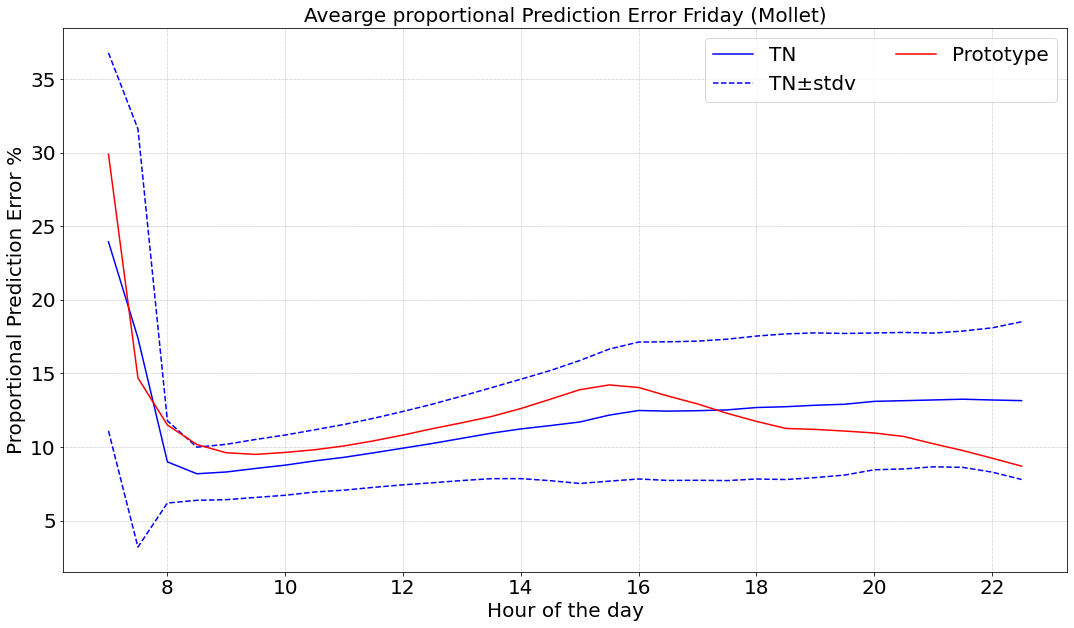

In [66]:

figH=plotRunningPredcitionErrorSTDV(tn_running_error_fr,proto_running_error_fr,starting_hour,day,current_parking)

### WEEKEND

### SATURDAY

In [67]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend_nooff
t_days = testing_saturdays
t_dates= testing_saturdays_dates
limit_hour = 16
day = 'Saturday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-02-29
Real Saturday scaled prtotype error:  2.39 %
Real Saturday scaled prtotype STDV:  1.5174121348169725
Real Saturday scaled TN error:  1.71 %
Real Saturday scaled TN STDV:  1.2777288606718835
_____________________________________________________________
2020-03-07
Real Saturday scaled prtotype error:  3.17 %
Real Saturday scaled prtotype STDV:  2.6588656610806902
Real Saturday scaled TN error:  1.86 %
Real Saturday scaled TN STDV:  1.2255986884086354
_____________________________________________________________
2020-03-14
Real Saturday scaled prtotype error:  2.46 %
Real Saturday scaled prtotype STDV:  1.2578046950463573
Real Saturday scaled TN error:  2.05 %
Real Saturday scaled TN STDV:  0.9665635404910888
_____________________________________________________________


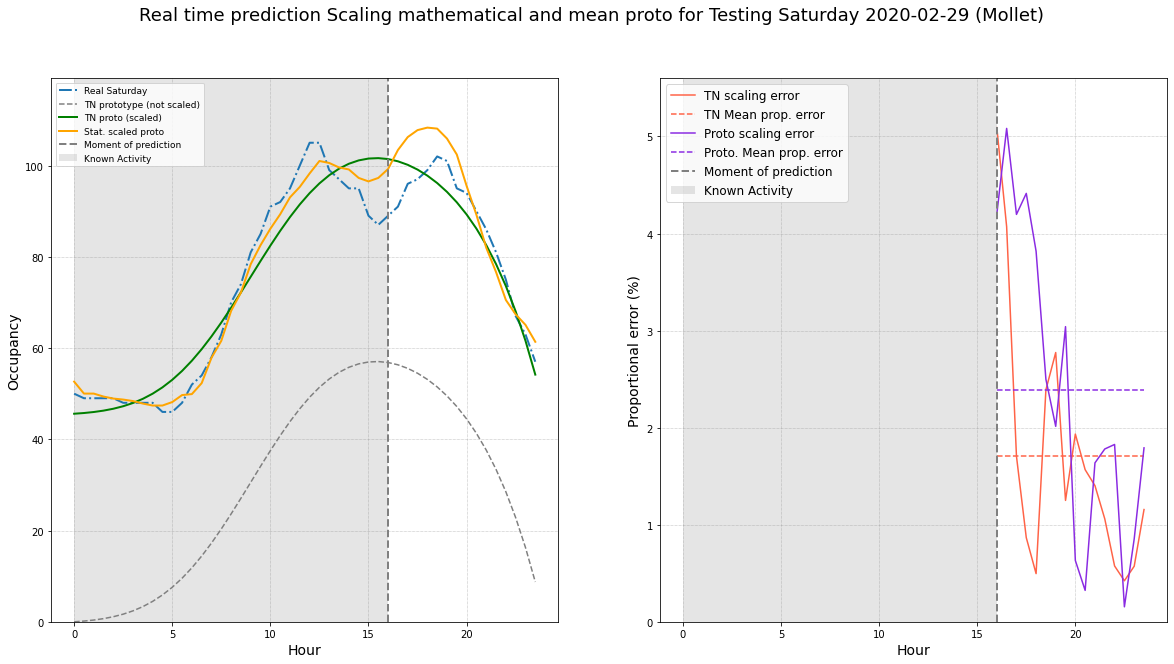

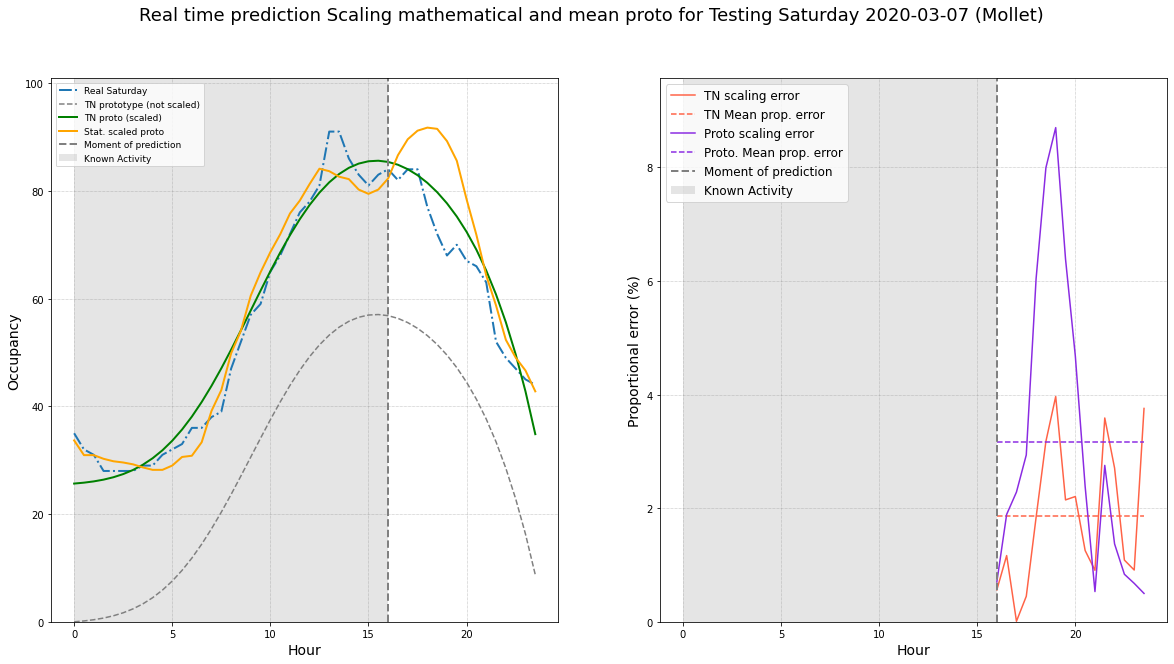

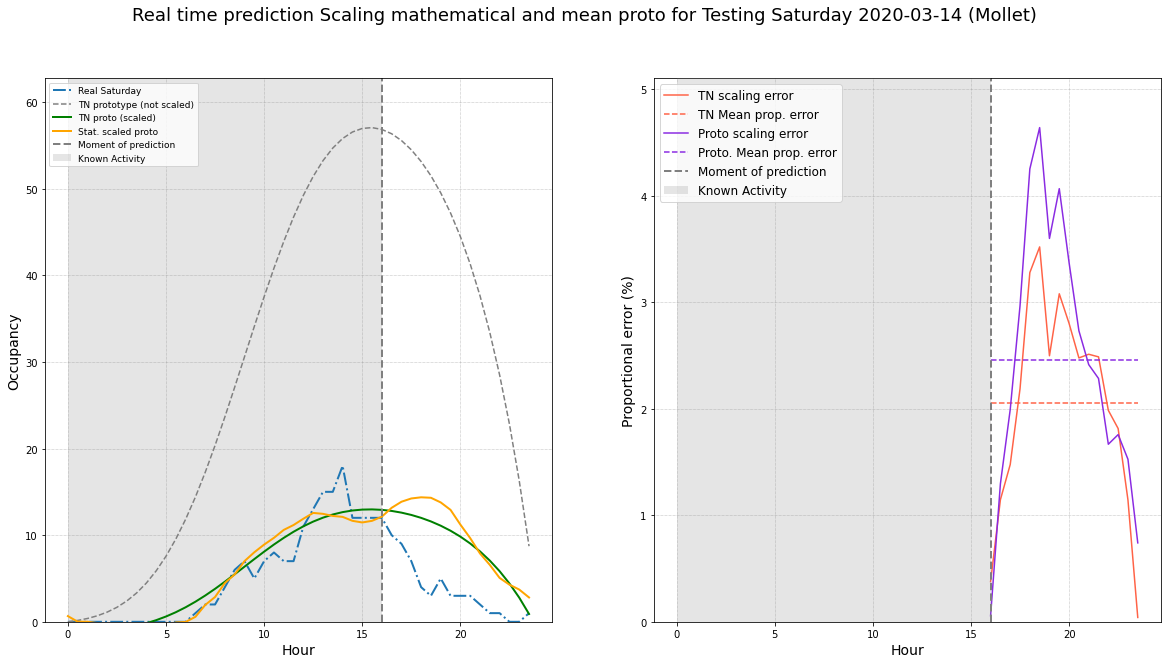

In [68]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

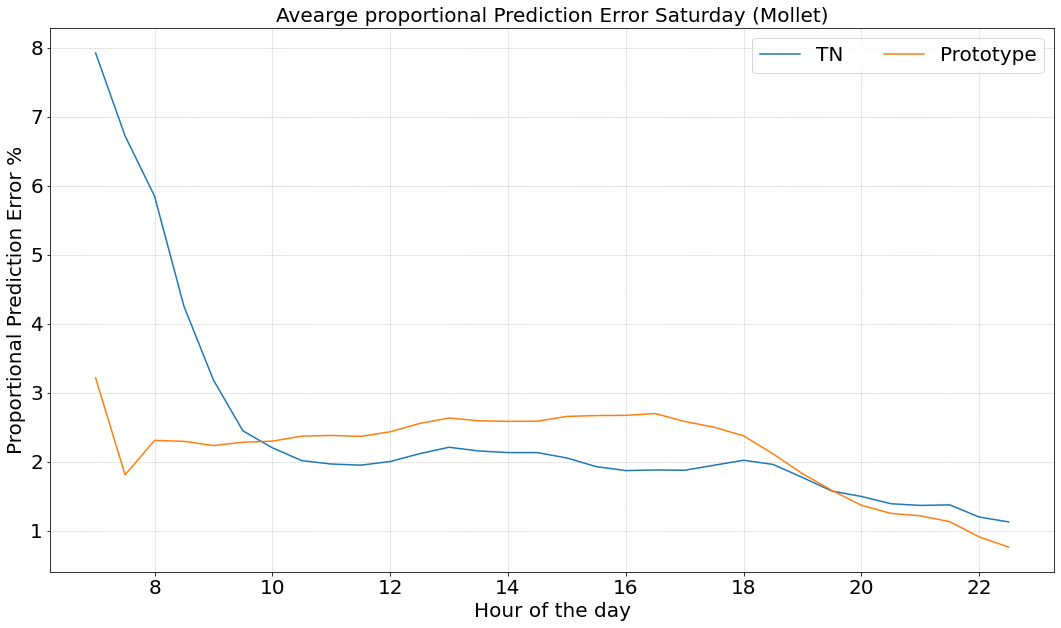

In [69]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [70]:
proto_running_error_we=proto_running_error_vec
tn_running_error_we=tn_running_error_vec

2020-02-29
Real Saturday scaled prtotype error:  1.92 %
Real Saturday scaled prtotype STDV:  1.4145536000335286
Real Saturday scaled TN error:  4.66 %
Real Saturday scaled TN STDV:  1.9988131124205344
_____________________________________________________________
2020-03-07
Real Saturday scaled prtotype error:  4.8 %
Real Saturday scaled prtotype STDV:  2.184637985997603
Real Saturday scaled TN error:  2.21 %
Real Saturday scaled TN STDV:  1.5346401362003017
_____________________________________________________________
2020-03-14
Real Saturday scaled prtotype error:  2.9 %
Real Saturday scaled prtotype STDV:  1.0890454975706614
Real Saturday scaled TN error:  2.51 %
Real Saturday scaled TN STDV:  0.9982496644166821
_____________________________________________________________


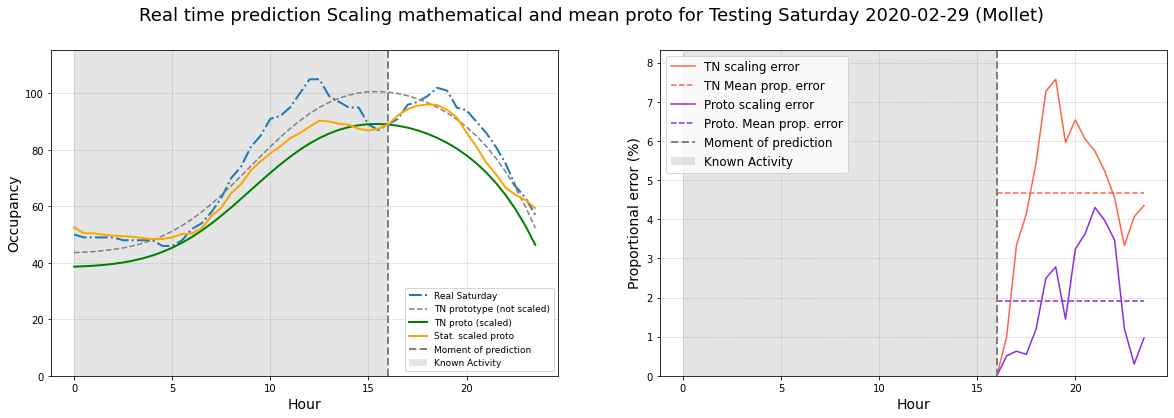

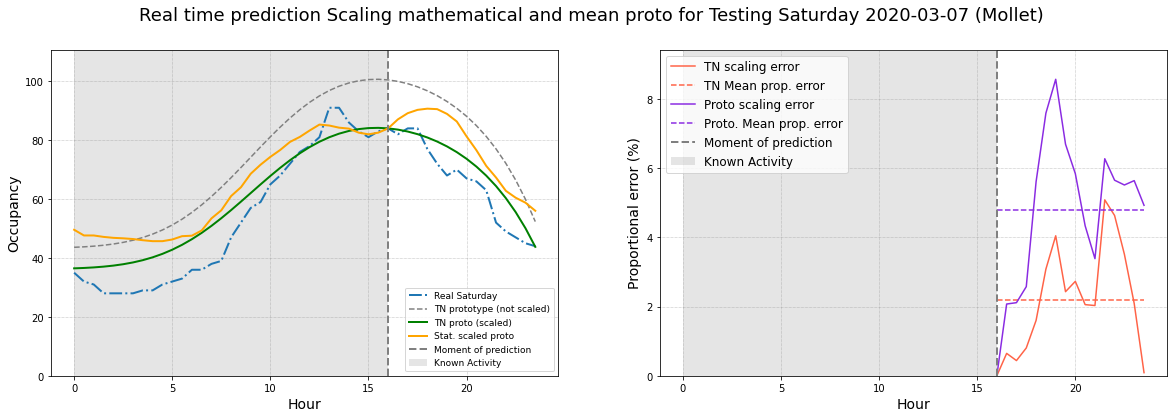

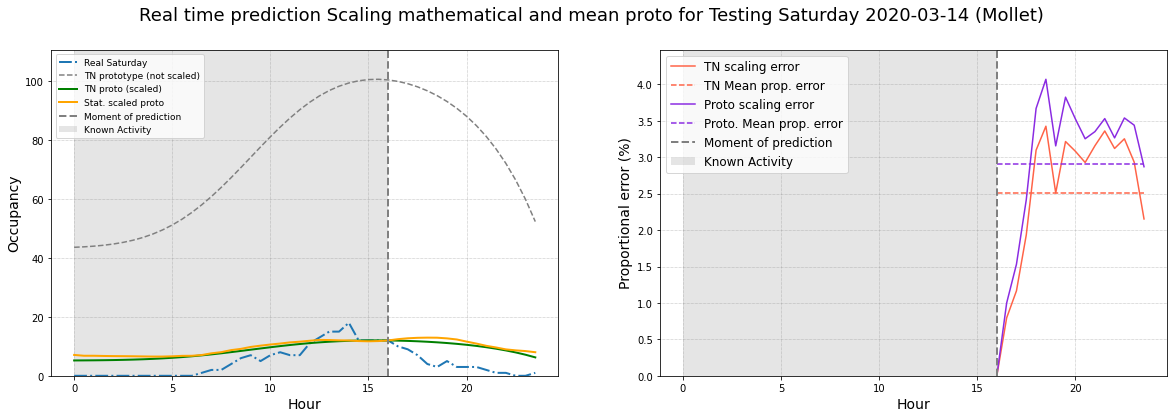

In [71]:
tn_proto = tn1_weekend   
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, 
                          scaled_stat_proto, limit_hour, t_date, current_parking)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

### SUNDAY

In [72]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend_nooff
t_days = testing_sundays
t_dates= testing_sundays_dates
limit_hour = 13
day = 'Sunday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

2020-03-01
Real Sunday scaled prtotype error:  2.79 %
Real Sunday scaled prtotype STDV:  1.5283547838953098
Real Sunday scaled TN error:  2.61 %
Real Sunday scaled TN STDV:  1.6729296379806793
_____________________________________________________________
2020-03-08
Real Sunday scaled prtotype error:  6.57 %
Real Sunday scaled prtotype STDV:  5.10454055650916
Real Sunday scaled TN error:  6.55 %
Real Sunday scaled TN STDV:  5.409190927799894
_____________________________________________________________
2020-03-15
Real Sunday scaled prtotype error:  0.57 %
Real Sunday scaled prtotype STDV:  0.4101311561842751
Real Sunday scaled TN error:  0.46 %
Real Sunday scaled TN STDV:  0.3329279605373561
_____________________________________________________________


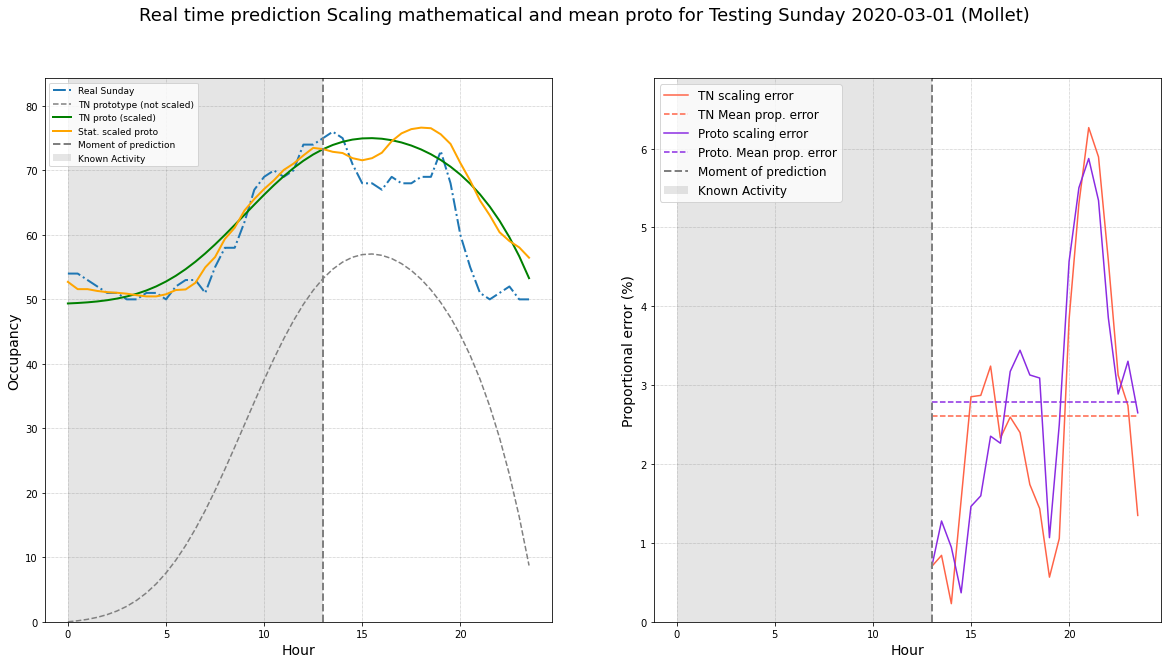

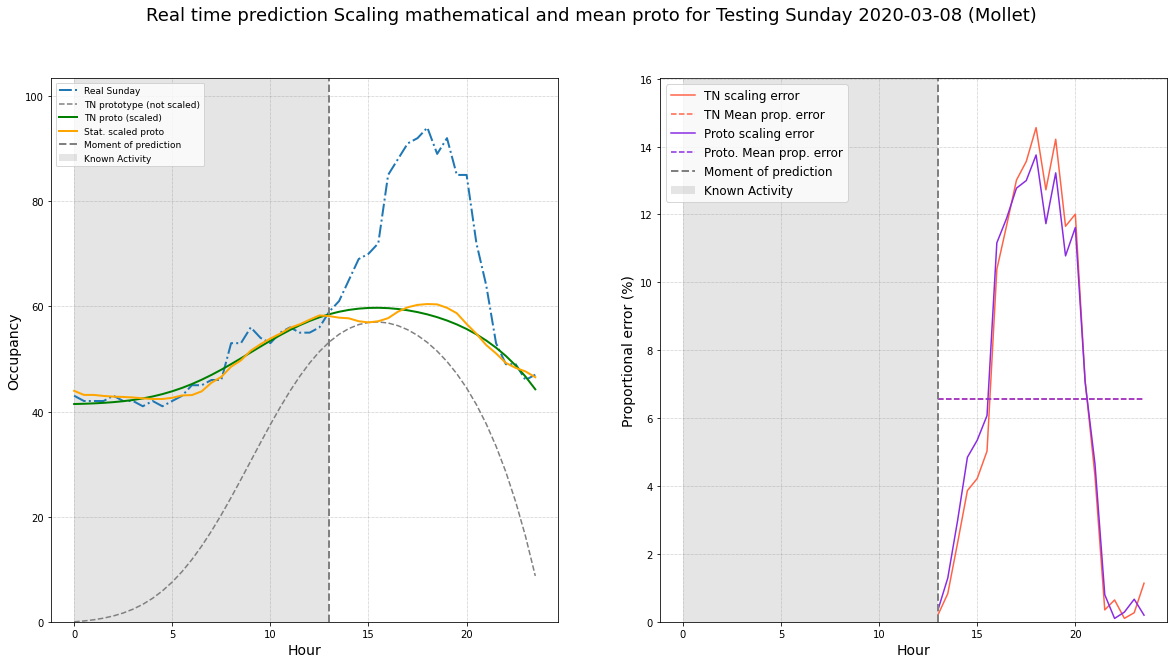

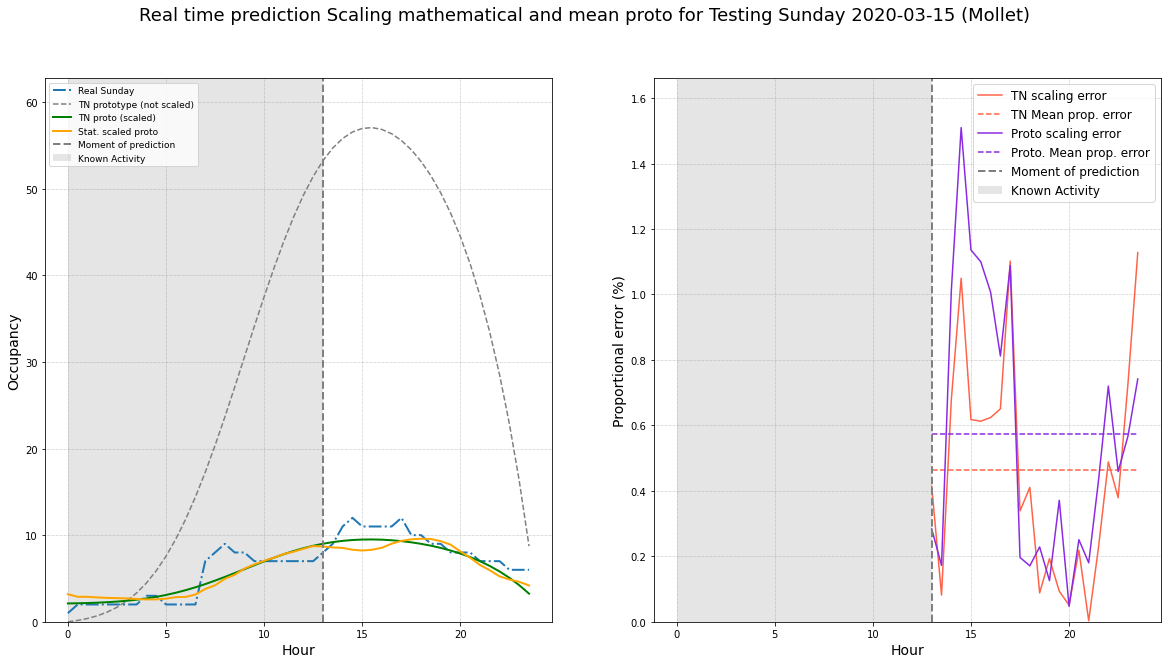

In [73]:
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor_and_constant(limit_hour, t_days[i], statistic_proto.values)
    scaled_tn_proto = tn_proto * tn_scaling.x[1]+tn_scaling.x[0]
    scaled_stat_proto = statistic_proto.values * stat_scaling.x[1]+stat_scaling.x[0]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], 
                          scaled_tn_proto, scaled_stat_proto, limit_hour, t_date, current_parking)
    axx=1;
    errors_plottingM(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour, max_value)
    cont=cont+1

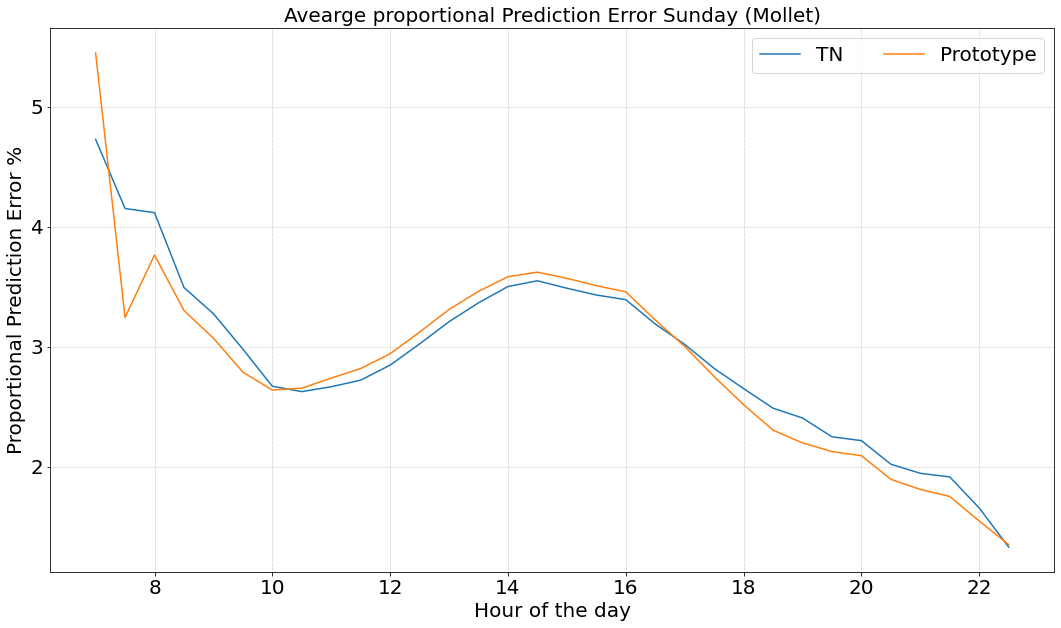

In [74]:
[tn_running_error_vec,proto_running_error_vec]=calcRunningPredcitionError(t_days,statistic_proto,
                                                                          tn_proto,max_value,starting_hour)
plotRunningPredcitionError(tn_running_error_vec,proto_running_error_vec,starting_hour,day,current_parking)

In [75]:
proto_running_error_we=np.concatenate((proto_running_error_we, proto_running_error_vec), axis=1)
tn_running_error_we=np.concatenate((tn_running_error_we, tn_running_error_vec), axis=1)

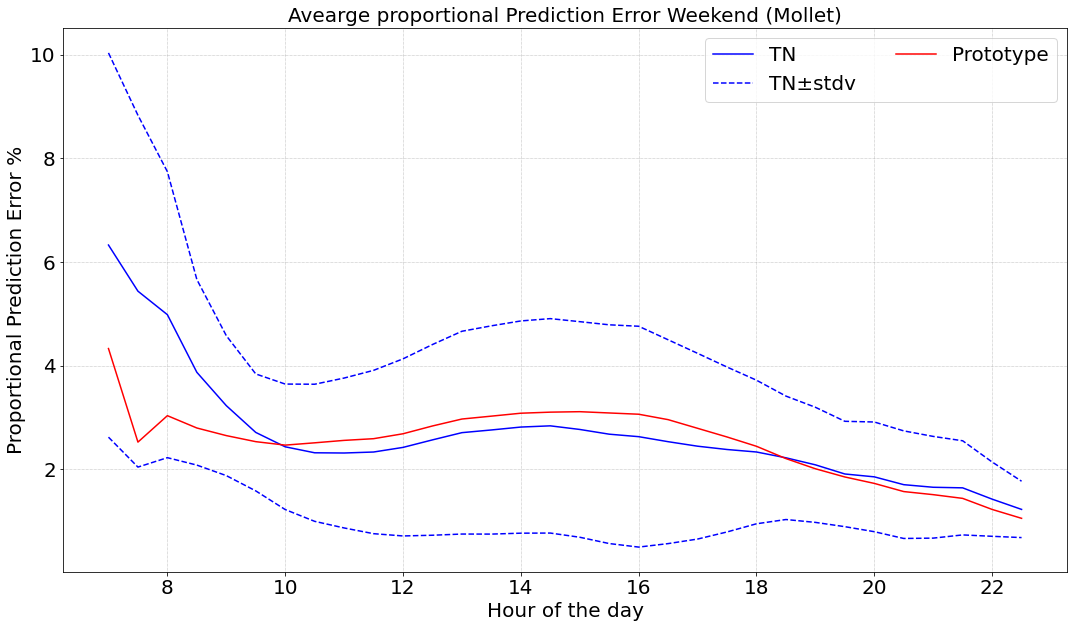

In [76]:
figH=plotRunningPredcitionErrorSTDV(tn_running_error_we,proto_running_error_we,starting_hour,"Weekend",current_parking)

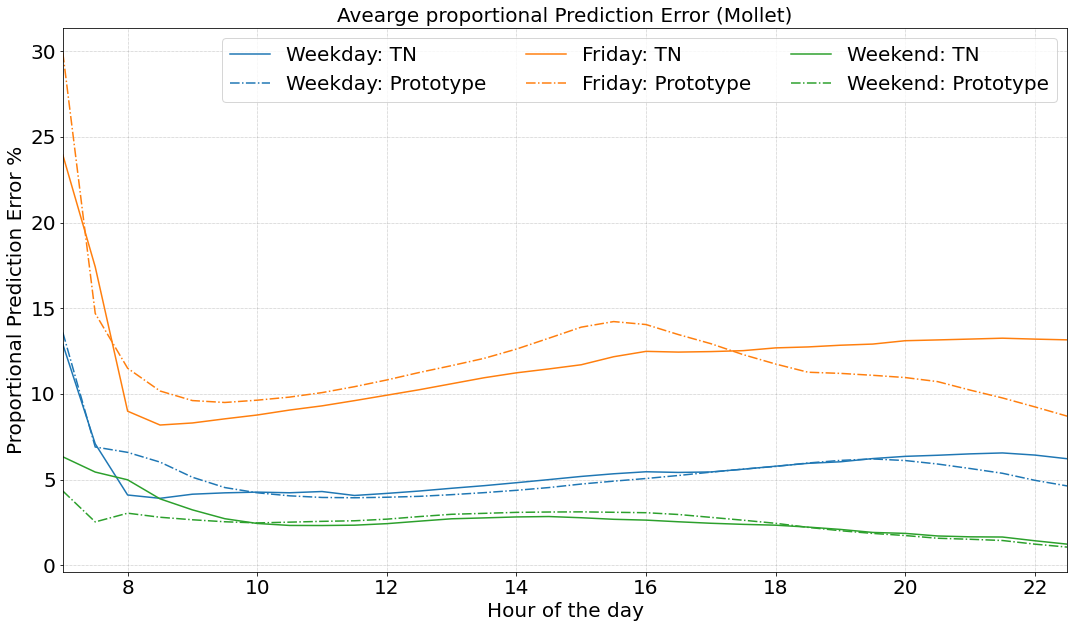

In [77]:
figH=plotRunningPredcitionErrorAgg(tn_running_error_wd,proto_running_error_wd,tn_running_error_fr,
                                  proto_running_error_fr,tn_running_error_we,proto_running_error_we,
                                  starting_hour,current_parking,False)
figH.savefig('RunningPredictionError_'+current_parking+'TH.pdf',bbox_inches='tight');